# Workshop: Time Series Forecasting (w. Machine Learning)

## Session 1: Time Series Forecasting Fundamentals

The fundamentals of **time series forecasting** -

Covering:

1. **Understanding Time Series Data** - formats, structures, and why they matter
2. **Time Series Components** - level, trend, seasonality, and noise
3. **Visualization & Decomposition** - seeing patterns in your data
4. **Simple Forecasting Methods** - baseline approaches (Naive, Seasonal Naive, Moving Averages)
5. **Statistical Models** - Exponential Smoothing (ETS)
6. **Model Evaluation** - measuring forecast accuracy

Let's get started!

## 1. Setup and Imports

First, let's import the libraries we'll need for this workshop.

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Forecasting library (we'll introduce this later)
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive, 
    SeasonalNaive, 
    WindowAverage, 
    SeasonalWindowAverage,
    AutoETS
)

# Set plotting style for clean, professional plots
plt.style.use('ggplot')

# Display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Understanding the Data

### 2.1 What is Our Dataset?

We're working with data from the **M5 Forecasting Competition** - a Walmart sales dataset.

**Key Details:**
- **What**: Daily sales of food products
- **Where**: 10 Walmart stores across 3 states (California, Texas, Wisconsin)
- **When**: January 1, 2013 to April 24, 2016 (~3.3 years)
- **Aggregation**: Store-level totals (all food items combined per store)

**The 10 Stores:**
- CA_1, CA_2, CA_3, CA_4 (California)
- TX_1, TX_2, TX_3 (Texas)
- WI_1, WI_2, WI_3 (Wisconsin)


**NOTE:** Data can be found here: https://www.kaggle.com/competitions/m5-forecasting-accuracy/data

In [102]:
# Load the data
data_path = '/home/filtheo/Cloud-for-AI/workshop_ml_2025/data/converted_df.csv'
df = pd.read_csv(data_path, parse_dates=['date'])

print(f"Dataset shape: {df.shape}")
print(f"Number of unique stores: {df['unique_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {df['date'].nunique()}")
print(f"\nFirst few rows:")
df.head(15)

Dataset shape: (12100, 3)
Number of unique stores: 10
Date range: 2013-01-01 00:00:00 to 2016-04-24 00:00:00
Total days: 1210

First few rows:


unique_id       date     y
0       CA_1 2013-01-01  1888
1       CA_2 2013-01-01  1320
2       CA_3 2013-01-01  2454
3       CA_4 2013-01-01  1031
4       TX_1 2013-01-01  1607
5       TX_2 2013-01-01  2469
6       TX_3 2013-01-01  1773
7       WI_1 2013-01-01  1365
8       WI_2 2013-01-01  1506
9       WI_3 2013-01-01  1415
10      CA_1 2013-01-02  2508
11      CA_2 2013-01-02  1587
12      CA_3 2013-01-02  3932
13      CA_4 2013-01-02  1226
14      TX_1 2013-01-02  1522

In [103]:
# Basic statistics
print("Basic Statistics per Store:")
print("="*70)
store_stats = df.groupby('unique_id')['y'].agg(['count', 'mean', 'std', 'min', 'max']).round(1)
store_stats

Basic Statistics per Store:


count    mean    std  min   max
unique_id                                 
CA_1        1210  2955.3  664.2    0  5016
CA_2        1210  1927.0  639.0    2  4467
CA_3        1210  4075.3  731.4    0  6488
CA_4        1210  1573.7  237.9    0  2420
TX_1        1210  2012.2  400.4    0  3978
TX_2        1210  2623.3  549.0    0  5251
TX_3        1210  2261.4  414.7    1  5104
WI_1        1210  2215.3  546.9    0  4715
WI_2        1210  2976.5  772.4    0  5902
WI_3        1210  2314.6  583.6    1  4411

### 2.2 Data Formats for Time Series

Time series data can be stored in two main formats. Each has its own advantages and use cases.

#### Format 1: Transactional Format (Long Format) ✅ **This is what we use**

**Structure:** One row per observation (date × unique_id combination)

| unique_id | date       | y    |
|-----------|------------|------|
| CA_1      | 2013-01-01 | 1888 |
| CA_2      | 2013-01-01 | 1320 |
| CA_1      | 2013-01-02 | 2508 |
| CA_2      | 2013-01-02 | 1587 |

**Advantages:**
- ✓ **Memory efficient** - stores data compactly
- ✓ **Supports covariates** - easy to add extra columns (holidays, promotions, weather, etc.)
- ✓ **Scalable** - works with millions of time series
- ✓ **Standard format** - required by most modern forecasting libraries (StatsForecast, NeuralForecast, etc.)

**Use case:** Production environments, large-scale forecasting, when you have additional features

---

#### Format 2: Pivoted Format (Wide Format)

**Structure:** One row per unique_id, one column per date

| unique_id | 2013-01-01 | 2013-01-02 | 2013-01-03 | ... |
|-----------|------------|------------|------------|-----|
| CA_1      | 1888       | 2508       | 2813       | ... |
| CA_2      | 1320       | 1587       | 1622       | ... |

**Advantages:**
- ✓ **Full overview** - see all series at once
- ✓ **Easy visualization** - natural for plotting
- ✓ **Quick inspection** - spot patterns across series

**Disadvantages:**
- ✗ **High memory usage** - especially with many dates
- ✗ **No covariates** - can't add extra features
- ✗ **Not scalable** - struggles with many series or long histories

**Use case:** Exploratory analysis, presentations, small datasets

Let's create both formats to see the difference:

In [104]:
# Our current format: TRANSACTIONAL (long format)
print("TRANSACTIONAL FORMAT (Current):")
print("="*70)
print(f"\nShape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head(20)

TRANSACTIONAL FORMAT (Current):

Shape: (12100, 3)
Memory usage: 0.89 MB


unique_id       date     y
0       CA_1 2013-01-01  1888
1       CA_2 2013-01-01  1320
2       CA_3 2013-01-01  2454
3       CA_4 2013-01-01  1031
4       TX_1 2013-01-01  1607
5       TX_2 2013-01-01  2469
6       TX_3 2013-01-01  1773
7       WI_1 2013-01-01  1365
8       WI_2 2013-01-01  1506
9       WI_3 2013-01-01  1415
10      CA_1 2013-01-02  2508
11      CA_2 2013-01-02  1587
12      CA_3 2013-01-02  3932
13      CA_4 2013-01-02  1226
14      TX_1 2013-01-02  1522
15      TX_2 2013-01-02  2342
16      TX_3 2013-01-02  1733
17      WI_1 2013-01-02  1808
18      WI_2 2013-01-02  3177
19      WI_3 2013-01-02  2813

In [105]:
# Create PIVOTED format for comparison
df_pivoted = df.pivot(index='unique_id', columns='date', values='y')

print("PIVOTED FORMAT (Wide):")
print("="*70)
print(f"\nShape: {df_pivoted.shape}")
print(f"Memory usage: {df_pivoted.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nNotice: {df_pivoted.shape[1]} columns (one per date)!")
df_pivoted.head()

PIVOTED FORMAT (Wide):

Shape: (10, 1210)


Memory usage: 0.09 MB

Notice: 1210 columns (one per date)!


date       2013-01-01  2013-01-02  2013-01-03  2013-01-04  2013-01-05  \
unique_id                                                               
CA_1             1888        2508        2813        2962        3320   
CA_2             1320        1587        1622        1637        2162   
CA_3             2454        3932        4332        4168        4793   
CA_4             1031        1226        1311        1387        1484   
TX_1             1607        1522        1979        1620        2403   

date       2013-01-06  2013-01-07  2013-01-08  2013-01-09  2013-01-10  \
unique_id                                                               
CA_1             3557        2847        2449        2118        2543   
CA_2             1942        1548        1503        1233        1459   
CA_3             5417        4252        4325        3809        4089   
CA_4             1789        1472        1246        1261        1409   
TX_1             2390        2241        1712        1815        1789   

date       2013-01-11  2013-01-12  2013-01-13  2013-01-14  2013-01-15  \
unique_id                                                               
CA_1             2837        3694        3351        2295        2194   
CA_2             1800        2276        2296        1478        1432   
CA_3             3783        5105        5210        3776        3406   
CA_4             1291        1797        1625        1326        1297   
TX_1             1919        2476        2785        1616        1863   

date       2013-01-16  2013-01-17  2013-01-18  2013-01-19  2013-01-20  \
unique_id                                                               
CA_1             1992        2150        2619        3533        2966   
CA_2             1486        1544        1679        2247        1810   
CA_3             3358        3293        3551        4533        4197   
CA_4             1166        1304        1411        1801        1546   
TX_1             1686        1433        1766        2162        2343   

date       2013-01-21  2013-01-22  2013-01-23  2013-01-24  2013-01-25  ...  \
unique_id                                                              ...   
CA_1             2537        1922        1807        1857        2264  ...   
CA_2             1693        1265        1178        1068        1675  ...   
CA_3             3819        3412        2848        2580        3230  ...   
CA_4             1430        1239        1101        1043        1336  ...   
TX_1             1842        1452        1324        1342        1577  ...   

date       2016-03-31  2016-04-01  2016-04-02  2016-04-03  2016-04-04  \
unique_id                                                               
CA_1             2651        3132        3890        4226        3273   
CA_2             2340        3081        3799        4150        2664   
CA_3             3432        3977        4466        5171        4195   
CA_4             1518        1701        1920        2074        1840   
TX_1             1588        2038        2351        2677        1895   

date       2016-04-05  2016-04-06  2016-04-07  2016-04-08  2016-04-09  \
unique_id                                                               
CA_1             2711        2698        2450        3141        4073   
CA_2             2293        2458        2451        2896        4118   
CA_3             4132        3829        3667        3937        4910   
CA_4             1665        1607        1586        1597        2091   
TX_1             2045        2061        2047        2087        2617   

date       2016-04-10  2016-04-11  2016-04-12  2016-04-13  2016-04-14  \
unique_id                                                               
CA_1             4061        2876        2372        2341        2421   
CA_2             4111        2621        2627        2264        2200   
CA_3             5453        4202        3692        3403        3344   
CA_4            

In [106]:
# Quick comparison
print("FORMAT COMPARISON:")
print("="*70)
print(f"Transactional: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Pivoted:       {df_pivoted.shape[0]} rows × {df_pivoted.shape[1]:,} columns")
print(f"\nMemory difference: {(df_pivoted.memory_usage(deep=True).sum() / df.memory_usage(deep=True).sum()):.1f}x more for pivoted")
print("\n💡 Key Takeaway: Transactional format is more efficient and flexible!")

FORMAT COMPARISON:
Transactional: 12,100 rows × 3 columns
Pivoted:       10 rows × 1,210 columns

Memory difference: 0.1x more for pivoted

💡 Key Takeaway: Transactional format is more efficient and flexible!


## 3. Time Series Visualization

Before we build models, we need to **understand our data visually**. Let's look for patterns:
- **Level**: The baseline value
- **Trend**: Overall upward or downward movement
- **Seasonality**: Repeating patterns (weekly, monthly, yearly)
- **Noise**: Random fluctuations

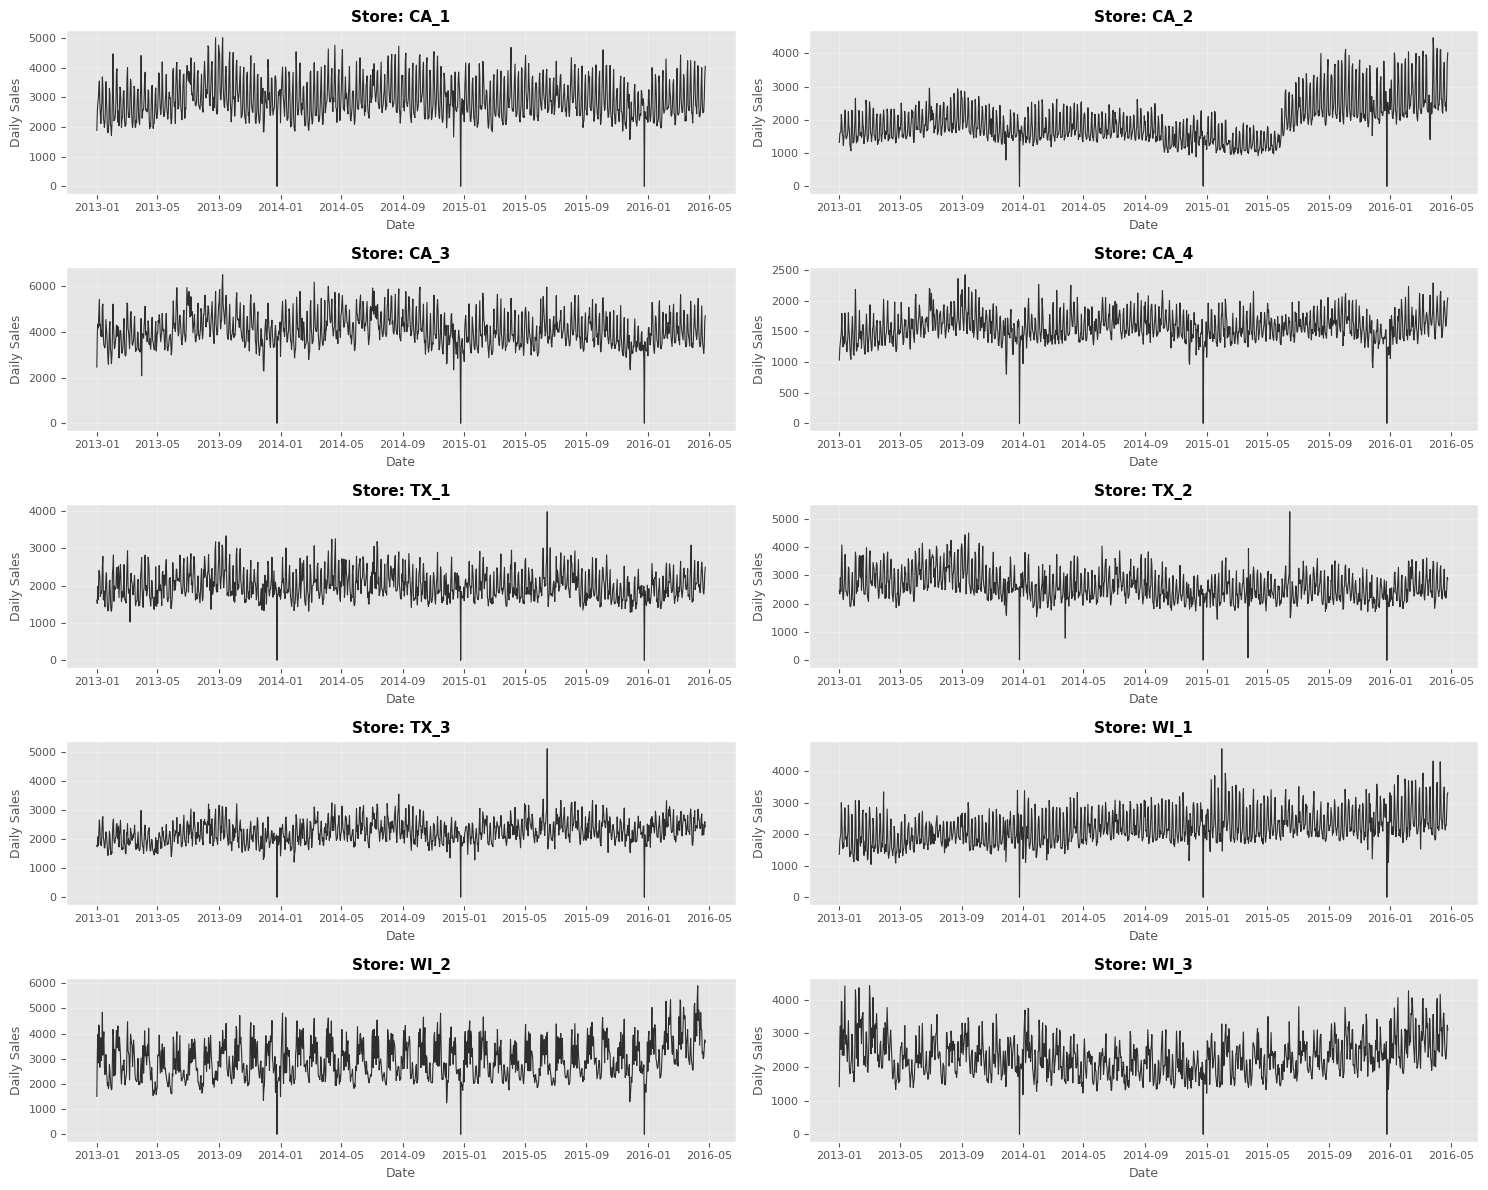


🔍 What patterns do you notice?
- Do all stores have similar sales levels?
- Can you spot any trends (increasing/decreasing over time)?
- Do you see repeating patterns (seasonality)?


In [107]:
# Plot all 10 stores in a grid
fig, axes = plt.subplots(5, 2, figsize=(15, 12))
axes = axes.flatten()

stores = df['unique_id'].unique()

for idx, store in enumerate(stores):
    store_data = df[df['unique_id'] == store].sort_values('date')
    
    axes[idx].plot(store_data['date'], store_data['y'], 
                   color='black', linewidth=0.8, alpha=0.8)
    axes[idx].set_title(f'Store: {store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=9)
    axes[idx].set_ylabel('Daily Sales', fontsize=9)
    axes[idx].tick_params(labelsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 What patterns do you notice?")
print("- Do all stores have similar sales levels?")
print("- Can you spot any trends (increasing/decreasing over time)?")
print("- Do you see repeating patterns (seasonality)?")

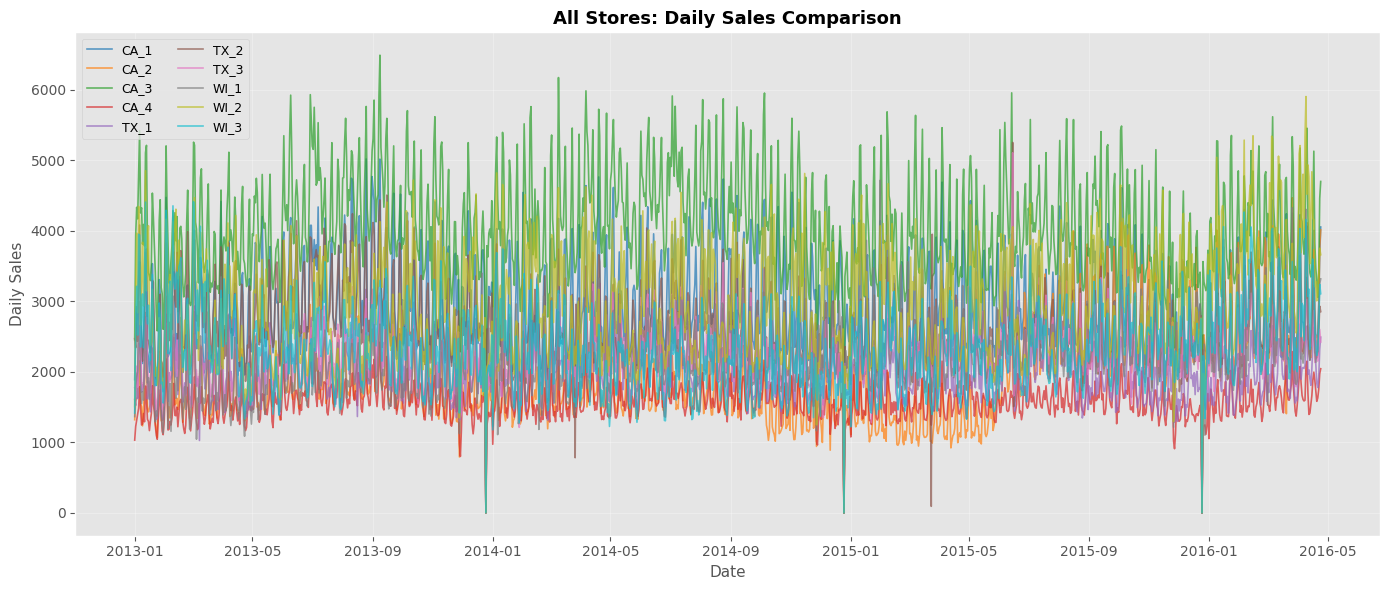


💡 Observations:
- Different stores operate at different scales
- Some stores show growth over time
- There appear to be regular weekly patterns (peaks and valleys)


In [108]:
# Plot all stores together for comparison
fig, ax = plt.subplots(figsize=(14, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(stores)))

for idx, store in enumerate(stores):
    store_data = df[df['unique_id'] == store].sort_values('date')
    ax.plot(store_data['date'], store_data['y'], 
            label=store, linewidth=1.2, alpha=0.7, color=colors[idx])

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Daily Sales', fontsize=11)
ax.set_title('All Stores: Daily Sales Comparison', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("- Different stores operate at different scales")
print("- Some stores show growth over time")
print("- There appear to be regular weekly patterns (peaks and valleys)")

## 4. Time Series Decomposition

### What is Decomposition?

Every time series can be broken down into fundamental components:

**Observed = Level + Trend + Seasonality + Noise**

- **Level (L)**: The baseline average value
- **Trend (T)**: Long-term increase or decrease
- **Seasonality (S)**: Regular, repeating patterns (weekly, monthly, yearly)
- **Noise (N)**: Random, unpredictable fluctuations

### Why Decompose?
1. **Understand patterns** - see what drives your data
2. **Choose models** - different models handle different components
3. **Improve forecasts** - model the structure, ignore the noise

Let's decompose a few stores to see their components!

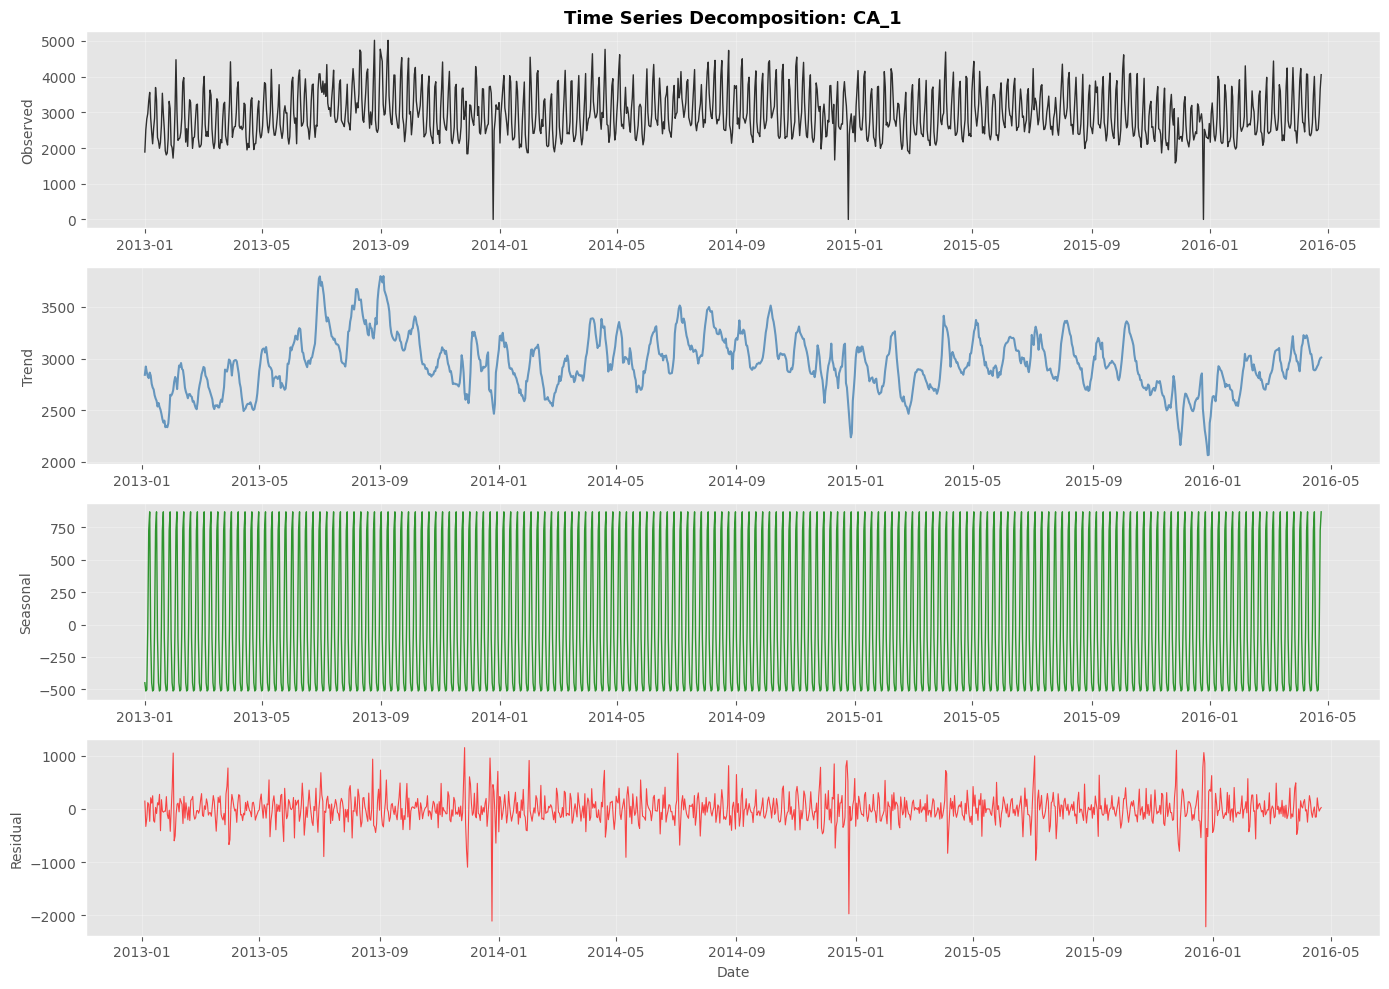


📊 Component Analysis:
- Trend: Shows upward movement over time
- Seasonal: Weekly pattern repeating every 7 days
- Residual: Random noise around zero


In [109]:
# Decompose Store CA_1
store_name = 'CA_1'
store_data = df[df['unique_id'] == store_name].sort_values('date').set_index('date')

# Perform seasonal decomposition (period=7 for weekly seasonality)
decomposition = seasonal_decompose(store_data['y'], model='additive', period=7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Observed
axes[0].plot(decomposition.observed, color='black', linewidth=1, alpha=0.8)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title(f'Time Series Decomposition: {store_name}', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend, color='steelblue', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal, color='green', linewidth=1, alpha=0.8)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Residual (Noise)
axes[3].plot(decomposition.resid, color='red', linewidth=0.8, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Component Analysis:")
print(f"- Trend: Shows {'upward' if decomposition.trend.dropna().iloc[-1] > decomposition.trend.dropna().iloc[0] else 'downward'} movement over time")
print(f"- Seasonal: Weekly pattern repeating every 7 days")
print(f"- Residual: Random noise around zero")

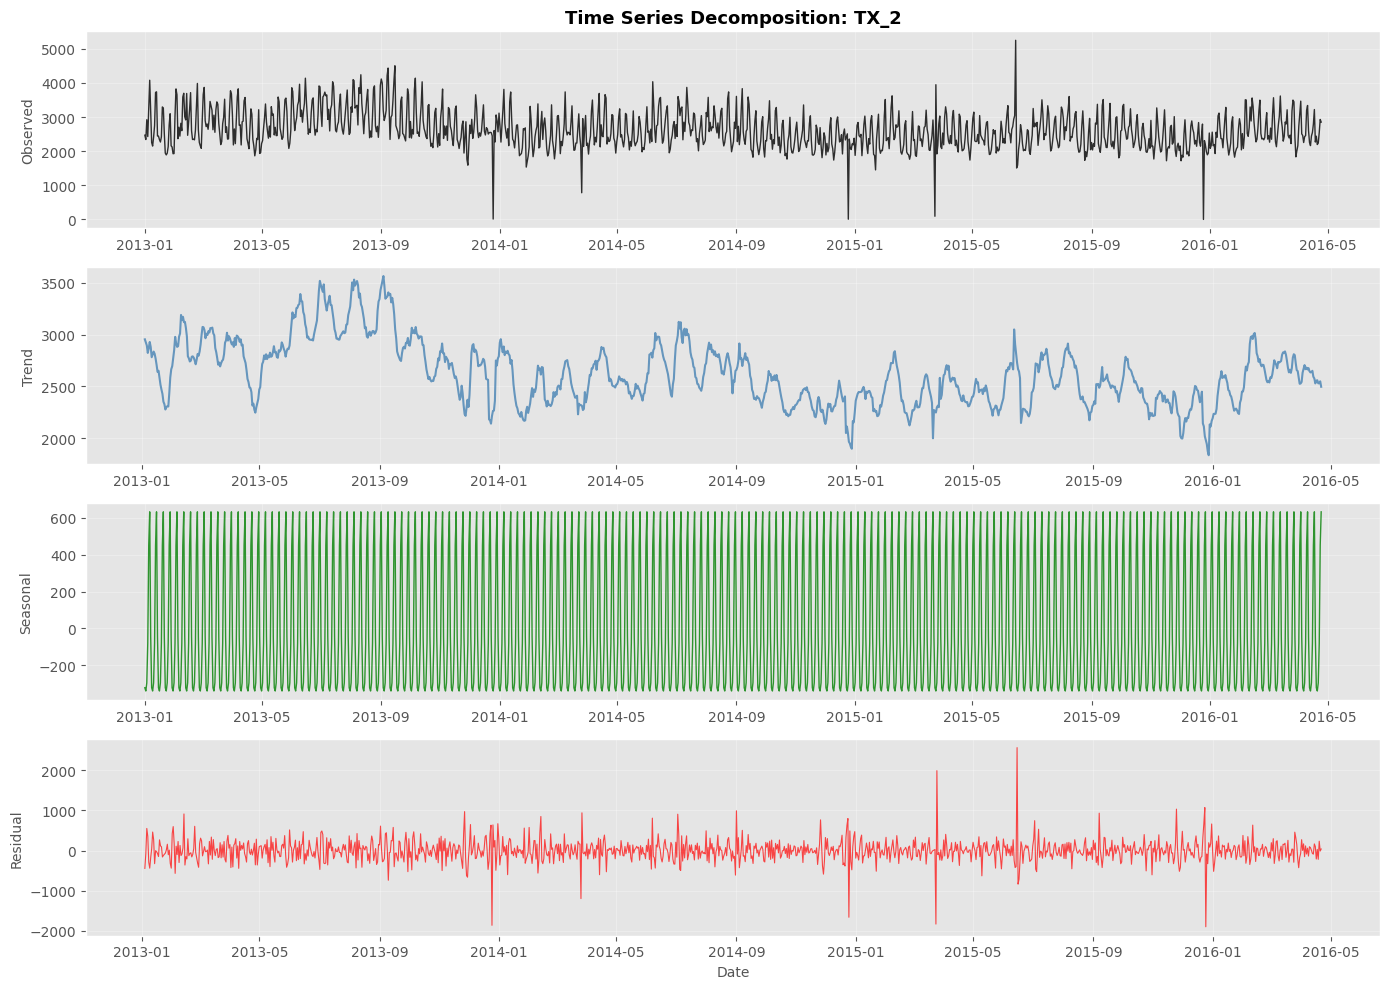

In [110]:
# Decompose Store TX_2
store_name = 'TX_2'
store_data = df[df['unique_id'] == store_name].sort_values('date').set_index('date')
decomposition = seasonal_decompose(store_data['y'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(decomposition.observed, color='black', linewidth=1, alpha=0.8)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title(f'Time Series Decomposition: {store_name}', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, color='steelblue', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, color='green', linewidth=1, alpha=0.8)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid, color='red', linewidth=0.8, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

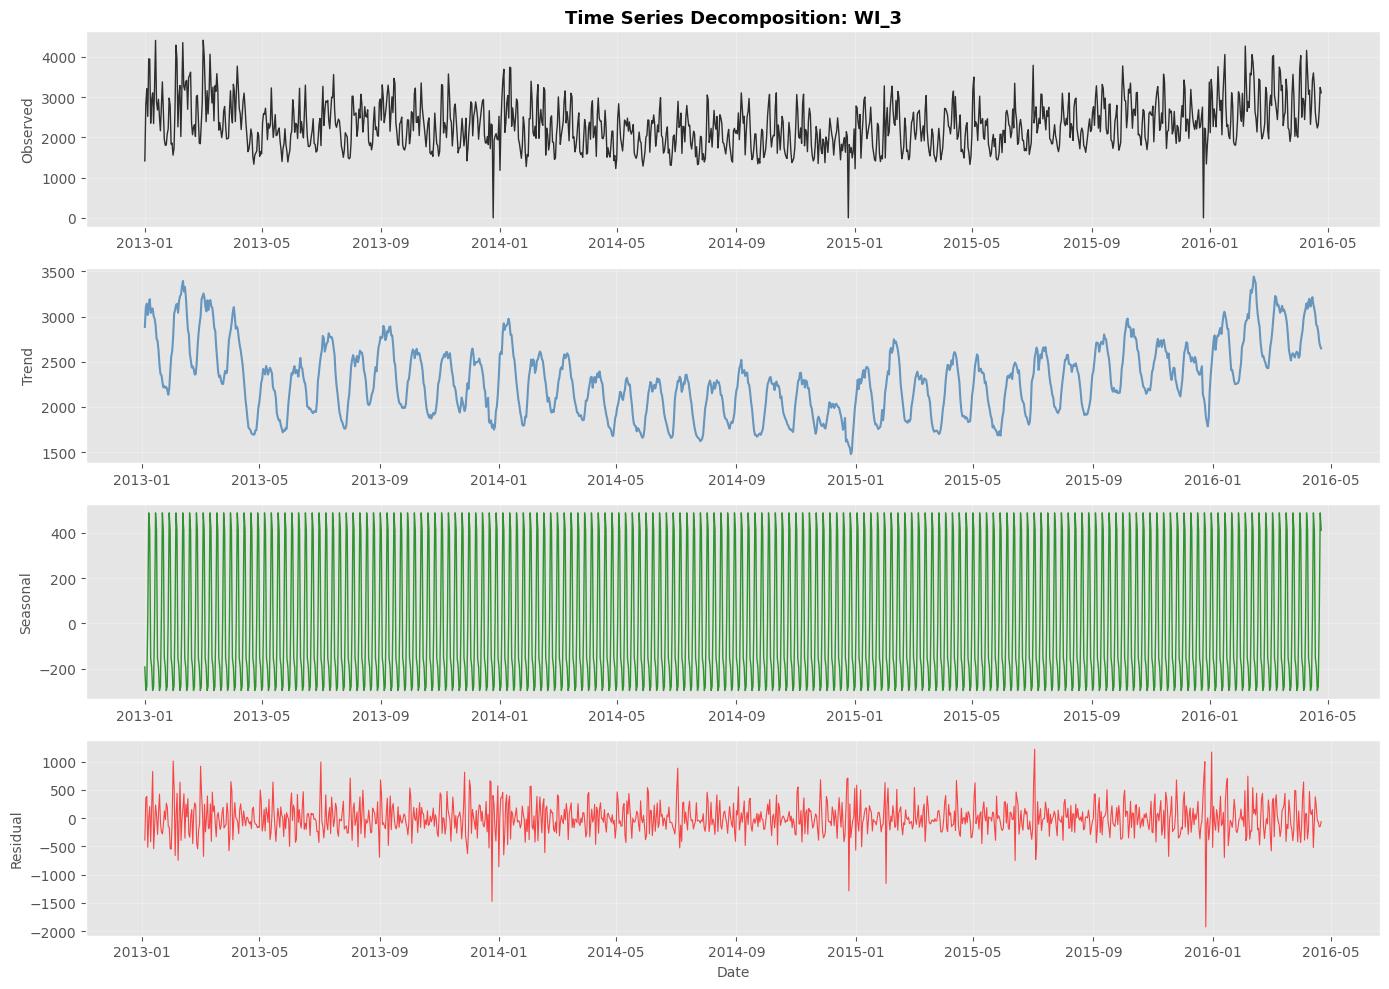

In [111]:
# Decompose Store WI_3
store_name = 'WI_3'
store_data = df[df['unique_id'] == store_name].sort_values('date').set_index('date')
decomposition = seasonal_decompose(store_data['y'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(decomposition.observed, color='black', linewidth=1, alpha=0.8)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title(f'Time Series Decomposition: {store_name}', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, color='steelblue', linewidth=1.5, alpha=0.8)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, color='green', linewidth=1, alpha=0.8)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid, color='red', linewidth=0.8, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Zoomed-In View: See the Weekly Pattern Clearly

Let's zoom into a 2-month window to clearly see the weekly seasonality!

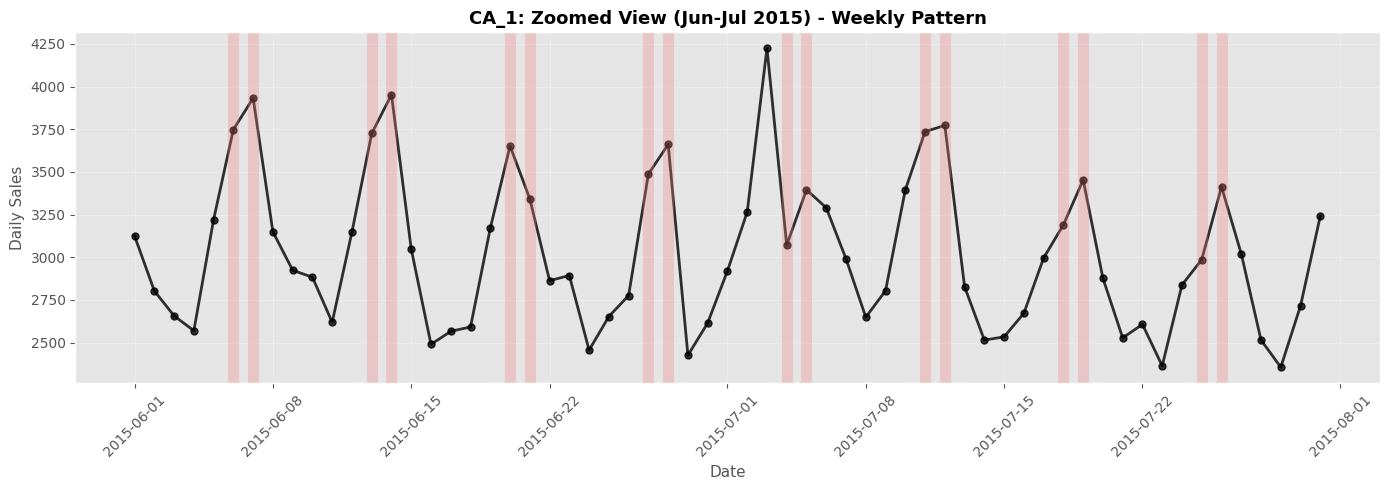


💡 Notice the weekly pattern:
- Light red shading = weekends (Saturday & Sunday)
- Sales tend to be higher on weekends
- The pattern repeats every 7 days


In [112]:
# Zoom into 2 months for CA_1 to see weekly pattern
store_name = 'CA_1'
store_data = df[df['unique_id'] == store_name].sort_values('date')

# Select 2 months in 2015 (middle of dataset)
start_date = '2015-06-01'
end_date = '2015-07-31'
zoom_data = store_data[(store_data['date'] >= start_date) & (store_data['date'] <= end_date)]

# Add day of week for better understanding
zoom_data = zoom_data.copy()
zoom_data['day_of_week'] = pd.to_datetime(zoom_data['date']).dt.day_name()

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(zoom_data['date'], zoom_data['y'], 
        color='black', linewidth=2, marker='o', markersize=5, alpha=0.8)

# Highlight weekends (Saturday and Sunday)
for idx, row in zoom_data.iterrows():
    if row['day_of_week'] in ['Saturday', 'Sunday']:
        ax.axvline(x=row['date'], color='lightcoral', alpha=0.3, linewidth=8)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Daily Sales', fontsize=11)
ax.set_title(f'{store_name}: Zoomed View (Jun-Jul 2015) - Weekly Pattern', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n💡 Notice the weekly pattern:")
print("- Light red shading = weekends (Saturday & Sunday)")
print("- Sales tend to be higher on weekends")
print("- The pattern repeats every 7 days")

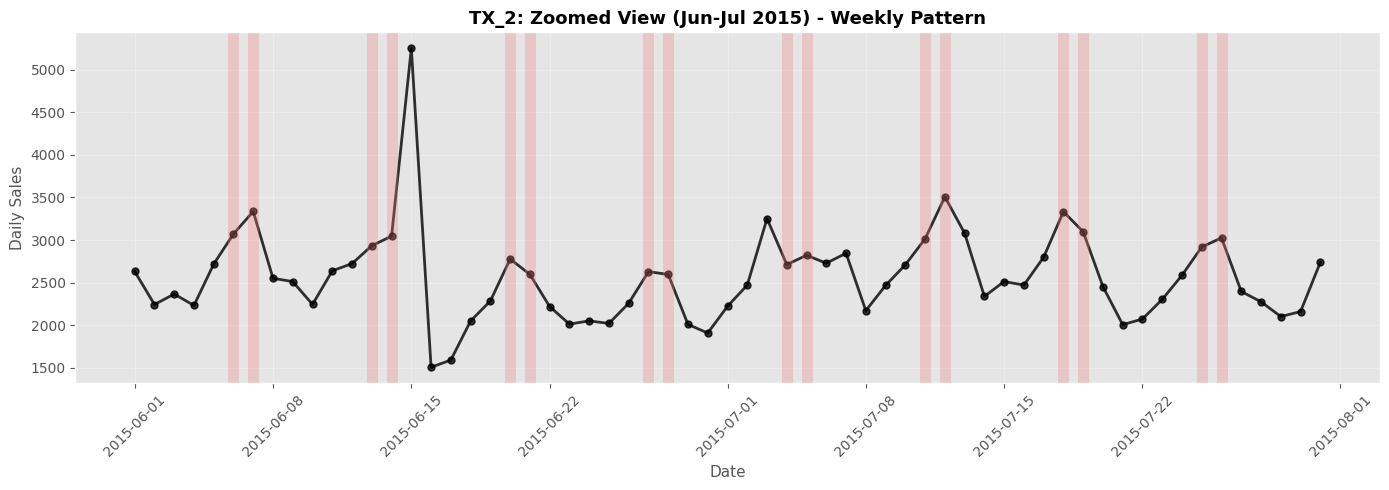

In [113]:
# Zoom for another store to compare patterns
store_name = 'TX_2'
store_data = df[df['unique_id'] == store_name].sort_values('date')
zoom_data = store_data[(store_data['date'] >= start_date) & (store_data['date'] <= end_date)].copy()
zoom_data['day_of_week'] = pd.to_datetime(zoom_data['date']).dt.day_name()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(zoom_data['date'], zoom_data['y'], 
        color='black', linewidth=2, marker='o', markersize=5, alpha=0.8)

for idx, row in zoom_data.iterrows():
    if row['day_of_week'] in ['Saturday', 'Sunday']:
        ax.axvline(x=row['date'], color='lightcoral', alpha=0.3, linewidth=8)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Daily Sales', fontsize=11)
ax.set_title(f'{store_name}: Zoomed View (Jun-Jul 2015) - Weekly Pattern', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Seasonality Analysis

Now let's quantify the strength of seasonality and examine the weekly patterns across all stores.

### 5.1 Strength of Seasonality

We can measure how strong the seasonal component is using:

**Seasonality Strength = 1 - Var(Residual) / Var(Seasonal + Residual)**

- Value close to **1** = **Strong seasonality**
- Value close to **0** = **Weak seasonality**

In [114]:
# Calculate seasonality strength for all stores
seasonality_strength = {}

for store in df['unique_id'].unique():
    store_data = df[df['unique_id'] == store].sort_values('date').set_index('date')
    decomp = seasonal_decompose(store_data['y'], model='additive', period=7)
    
    # Calculate strength
    seasonal_var = np.var(decomp.seasonal.dropna())
    resid_var = np.var(decomp.resid.dropna())
    
    strength = 1 - (resid_var / (seasonal_var + resid_var))
    seasonality_strength[store] = strength

# Convert to DataFrame for plotting
strength_df = pd.DataFrame(list(seasonality_strength.items()), 
                           columns=['Store', 'Seasonality_Strength'])
strength_df = strength_df.sort_values('Seasonality_Strength', ascending=False)

print("Seasonality Strength by Store:")
print("="*50)
print(strength_df.to_string(index=False))
print(f"\nAverage strength: {strength_df['Seasonality_Strength'].mean():.3f}")

Seasonality Strength by Store:
Store  Seasonality_Strength
 CA_1              0.793621
 CA_2              0.723152
 WI_1              0.709820
 CA_3              0.667192
 TX_1              0.651790
 TX_2              0.626825
 CA_4              0.555152
 WI_3              0.538660
 TX_3              0.502174
 WI_2              0.229361

Average strength: 0.600


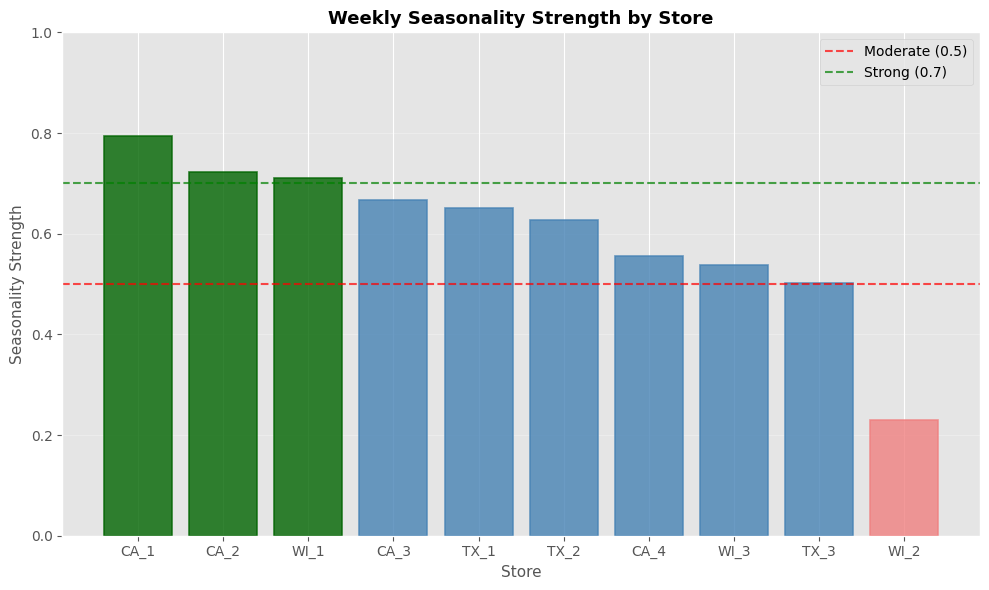


💡 Interpretation:
- Green bars: Strong weekly seasonality (>0.7)
- Blue bars: Moderate seasonality (0.5-0.7)
- Red bars: Weak seasonality (<0.5)

All stores show clear weekly patterns!


In [115]:
# Plot seasonality strength
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(strength_df['Store'], strength_df['Seasonality_Strength'], 
              color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.2)

# Color bars based on strength
for i, bar in enumerate(bars):
    if strength_df.iloc[i]['Seasonality_Strength'] > 0.7:
        bar.set_color('darkgreen')
    elif strength_df.iloc[i]['Seasonality_Strength'] > 0.5:
        bar.set_color('steelblue')
    else:
        bar.set_color('lightcoral')

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Moderate (0.5)')
ax.axhline(y=0.7, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Strong (0.7)')

ax.set_xlabel('Store', fontsize=11)
ax.set_ylabel('Seasonality Strength', fontsize=11)
ax.set_title('Weekly Seasonality Strength by Store', fontsize=13, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- Green bars: Strong weekly seasonality (>0.7)")
print("- Blue bars: Moderate seasonality (0.5-0.7)")
print("- Red bars: Weak seasonality (<0.5)")
print("\nAll stores show clear weekly patterns!")

### 5.2 Weekly Patterns: Day of Week Analysis

Let's examine which days of the week have highest/lowest sales.

Average Sales by Day of Week (All Stores Combined):
day_of_week           y
     Monday 2406.769767
    Tuesday 2230.205202
  Wednesday 2190.933526
   Thursday 2202.195376
     Friday 2444.671098
   Saturday 2961.747399
     Sunday 3017.162428


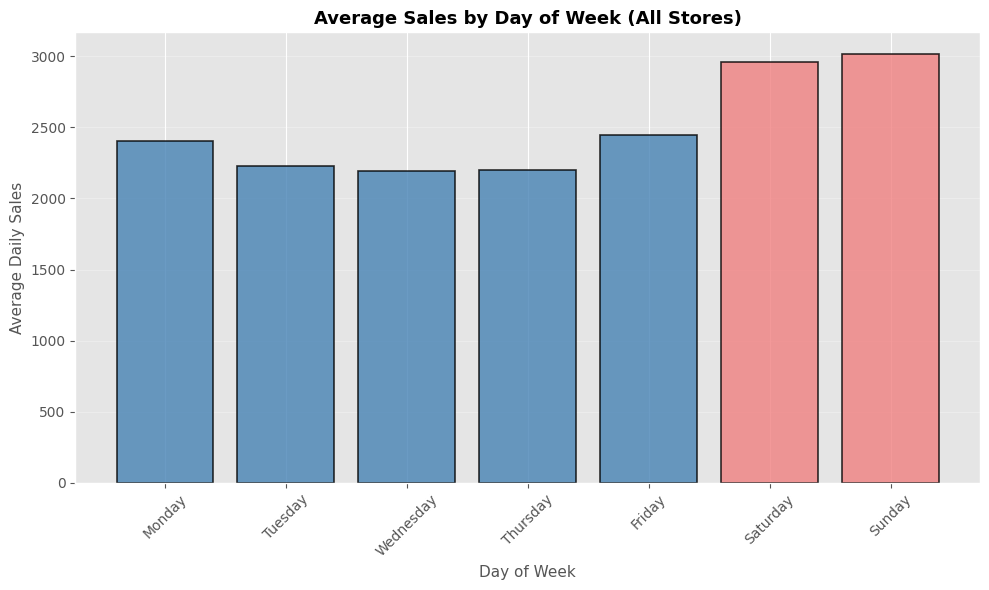


📈 Highest sales: Sunday
📉 Lowest sales: Wednesday


In [116]:
# Add day of week to dataset
df_dow = df.copy()
df_dow['day_of_week'] = pd.to_datetime(df_dow['date']).dt.day_name()
df_dow['dow_num'] = pd.to_datetime(df_dow['date']).dt.dayofweek

# Calculate average sales by day of week (across all stores)
dow_avg = df_dow.groupby(['dow_num', 'day_of_week'])['y'].mean().reset_index()
dow_avg = dow_avg.sort_values('dow_num')

print("Average Sales by Day of Week (All Stores Combined):")
print("="*60)
print(dow_avg[['day_of_week', 'y']].to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['steelblue']*5 + ['lightcoral']*2  # Highlight weekends
ax.bar(dow_avg['day_of_week'], dow_avg['y'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Day of Week', fontsize=11)
ax.set_ylabel('Average Daily Sales', fontsize=11)
ax.set_title('Average Sales by Day of Week (All Stores)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find peak day
peak_day = dow_avg.loc[dow_avg['y'].idxmax(), 'day_of_week']
low_day = dow_avg.loc[dow_avg['y'].idxmin(), 'day_of_week']
print(f"\n📈 Highest sales: {peak_day}")
print(f"📉 Lowest sales: {low_day}")

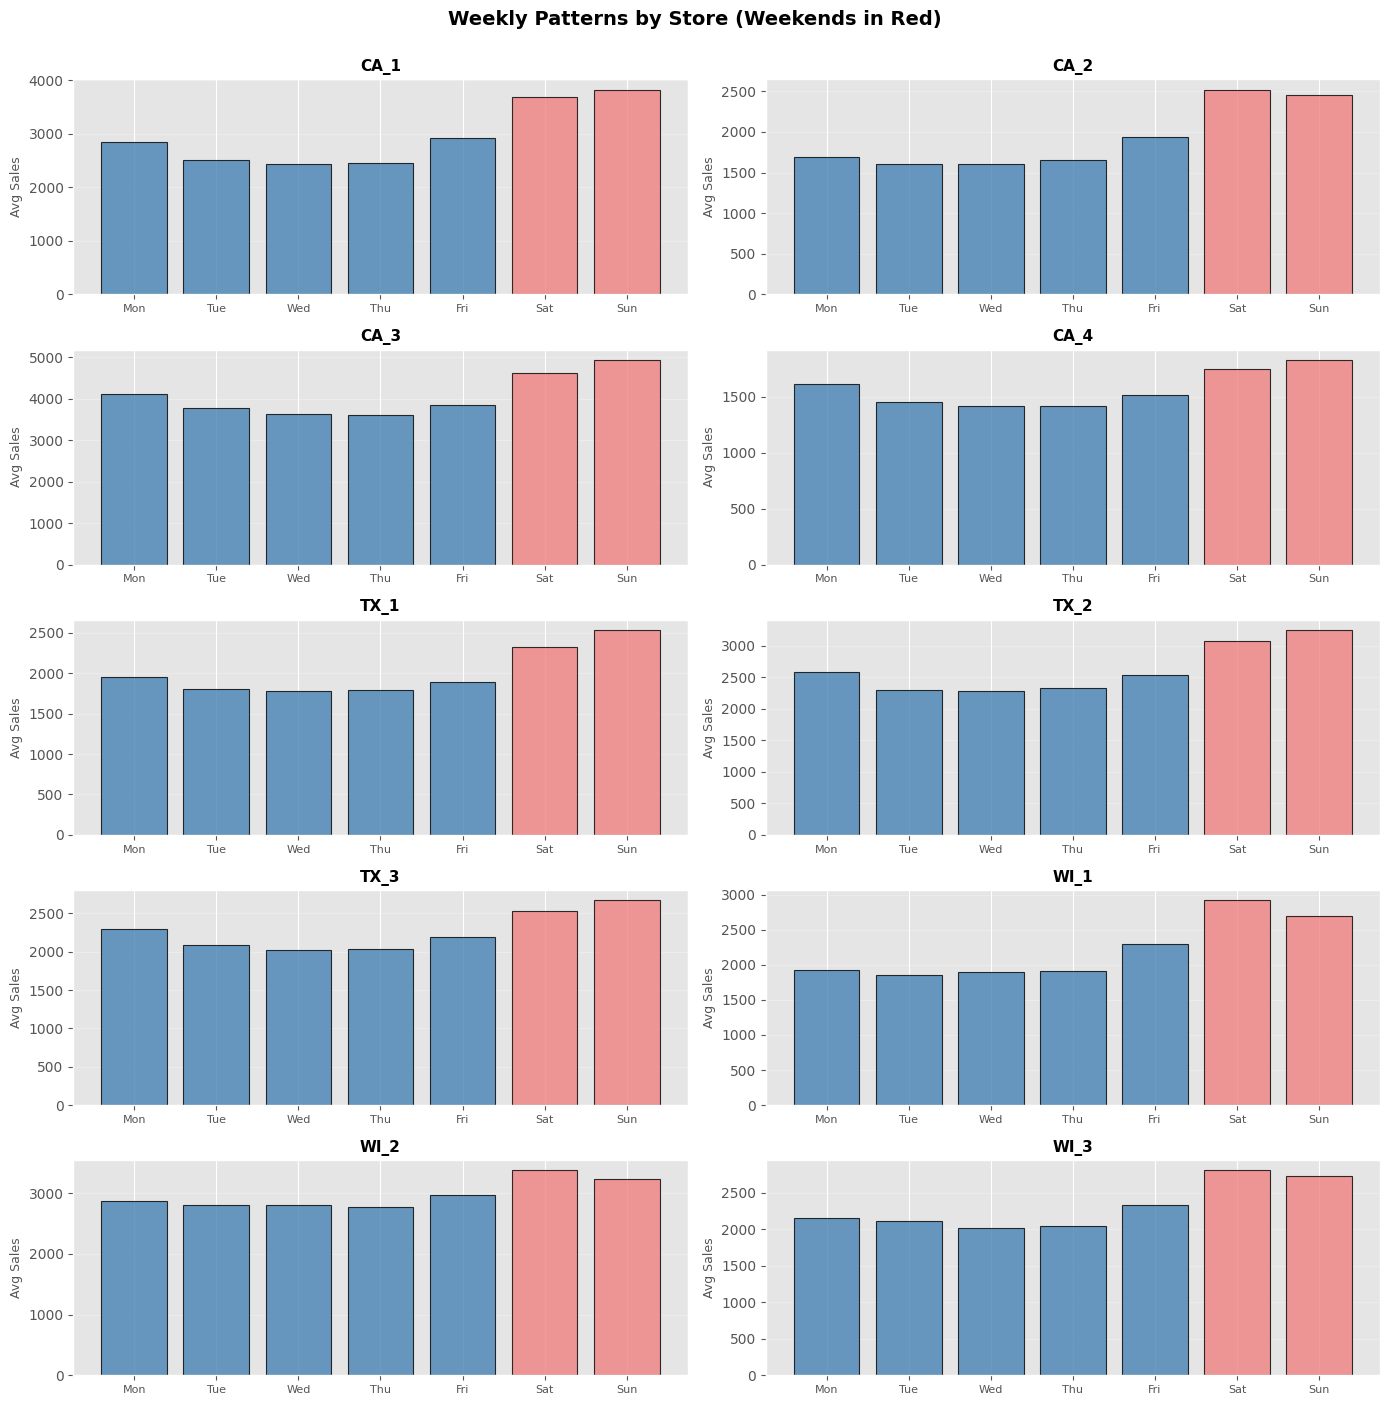


💡 Key Observations:
- Most stores have higher sales on weekends (Saturday/Sunday)
- Clear weekly cyclical pattern across all stores
- This seasonality should be captured by our forecasting models!


In [117]:
# Day of week patterns per store
fig, axes = plt.subplots(5, 2, figsize=(14, 14))
axes = axes.flatten()

stores = df_dow['unique_id'].unique()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for idx, store in enumerate(stores):
    store_dow = df_dow[df_dow['unique_id'] == store].groupby('day_of_week')['y'].mean().reindex(day_order)
    
    colors = ['steelblue']*5 + ['lightcoral']*2
    axes[idx].bar(range(7), store_dow.values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(range(7))
    axes[idx].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=8)
    axes[idx].set_ylabel('Avg Sales', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Weekly Patterns by Store (Weekends in Red)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("- Most stores have higher sales on weekends (Saturday/Sunday)")
print("- Clear weekly cyclical pattern across all stores")
print("- This seasonality should be captured by our forecasting models!")

## 6. Introduction to StatsForecast

Now that we understand our data, let's start forecasting!

### What is StatsForecast?

**StatsForecast** is a high-performance Python library for time series forecasting developed by Nixtla.

**Key Features:**
- ⚡ **Lightning Fast**: 20-500x faster than alternatives (uses Numba for compilation)
- 📊 **Production-Ready**: Designed for real-world forecasting at scale
- 🔧 **Easy to Use**: Simple, consistent API
- 📦 **Rich Model Library**: From simple baselines to advanced statistical models

**Available Models:**
- **Baseline Methods**: Naive, Seasonal Naive, Moving Averages
- **Exponential Smoothing**: ETS, Holt, Holt-Winters
- **ARIMA Family**: AutoARIMA, ARIMA, AutoRegressive
- **Theta Models**: Theta, Optimized Theta
- And many more!

**Resources:**
- GitHub: https://github.com/Nixtla/statsforecast
- Documentation: https://nixtlaverse.nixtla.io/statsforecast/

### Data Format for StatsForecast

StatsForecast requires a specific column naming:
- `unique_id`: Identifier for each time series
- `ds`: Date/timestamp (stands for "datestamp")
- `y`: The target variable (value to forecast)

Let's prepare our data!

In [118]:
# Prepare data for StatsForecast
# Rename 'date' to 'ds' (datestamp)
df_forecast = df.copy()
df_forecast = df_forecast.rename(columns={'date': 'ds'})

print("Data prepared for StatsForecast:")
print("="*60)
print(df_forecast.head())
print(f"\nColumns: {list(df_forecast.columns)}")
print("✅ Format ready: unique_id, ds, y")

Data prepared for StatsForecast:
  unique_id         ds     y
0      CA_1 2013-01-01  1888
1      CA_2 2013-01-01  1320
2      CA_3 2013-01-01  2454
3      CA_4 2013-01-01  1031
4      TX_1 2013-01-01  1607

Columns: ['unique_id', 'ds', 'y']
✅ Format ready: unique_id, ds, y


### Train/Test Split

To evaluate our forecasts, we need to:
1. **Train** on historical data
2. **Test** on recent data (that we hold out)
3. **Compare** our forecasts to actual values

We'll hold out the **last 28 days** (4 weeks) for testing.

In [146]:
# Train/Test split: last 28 days for testing
test_size = 14

# Find the split date
max_date = df_forecast['ds'].max()
split_date = max_date - pd.Timedelta(days=test_size - 1)

# Split the data
df_train = df_forecast[df_forecast['ds'] < split_date].copy()
df_test = df_forecast[df_forecast['ds'] >= split_date].copy()

print(f"Train/Test Split:")
print("="*60)
print(f"Total observations: {len(df_forecast):,}")
print(f"Training set: {len(df_train):,} observations")
print(f"Test set: {len(df_test):,} observations")
print(f"\nDate ranges:")
print(f"  Train: {df_train['ds'].min()} to {df_train['ds'].max()}")
print(f"  Test:  {df_test['ds'].min()} to {df_test['ds'].max()}")
print(f"\nForecast horizon: {test_size} days (4 weeks)")

Train/Test Split:
Total observations: 12,100
Training set: 11,960 observations
Test set: 140 observations

Date ranges:
  Train: 2013-01-01 00:00:00 to 2016-04-10 00:00:00
  Test:  2016-04-11 00:00:00 to 2016-04-24 00:00:00

Forecast horizon: 14 days (4 weeks)


## 7. Simple Forecasting Methods

Before diving into complex models, let's start with **simple baseline methods**. These are:
- Easy to understand and implement
- Fast to compute
- Often surprisingly effective
- Excellent benchmarks for more complex models

**The Golden Rule**: If a complex model can't beat these simple methods, don't use it!

### 7.1 Naive Method

**Concept**: The simplest possible forecast - just repeat the last observed value.

**Formula**: ŷ_{t+h} = y_t

**When to use**: Flat time series with no trend or seasonality (like stock prices, random walks)

In [147]:
# Fit Naive model
sf_naive = StatsForecast(
    models=[Naive()],
    freq='D',  # Daily frequency
    n_jobs=-1  # Use all CPU cores
)

# Generate forecasts
forecasts_naive = sf_naive.forecast(df=df_train, h=test_size)

print("Naive Forecasts:")
print("="*60)
print(forecasts_naive.head(10))
print(f"\nShape: {forecasts_naive.shape}")
print(f"Forecasts generated for {len(forecasts_naive['unique_id'].unique())} stores")

Naive Forecasts:
  unique_id         ds   Naive
0      CA_1 2016-04-11  4061.0
1      CA_1 2016-04-12  4061.0
2      CA_1 2016-04-13  4061.0
3      CA_1 2016-04-14  4061.0
4      CA_1 2016-04-15  4061.0
5      CA_1 2016-04-16  4061.0
6      CA_1 2016-04-17  4061.0
7      CA_1 2016-04-18  4061.0
8      CA_1 2016-04-19  4061.0
9      CA_1 2016-04-20  4061.0

Shape: (140, 3)
Forecasts generated for 10 stores


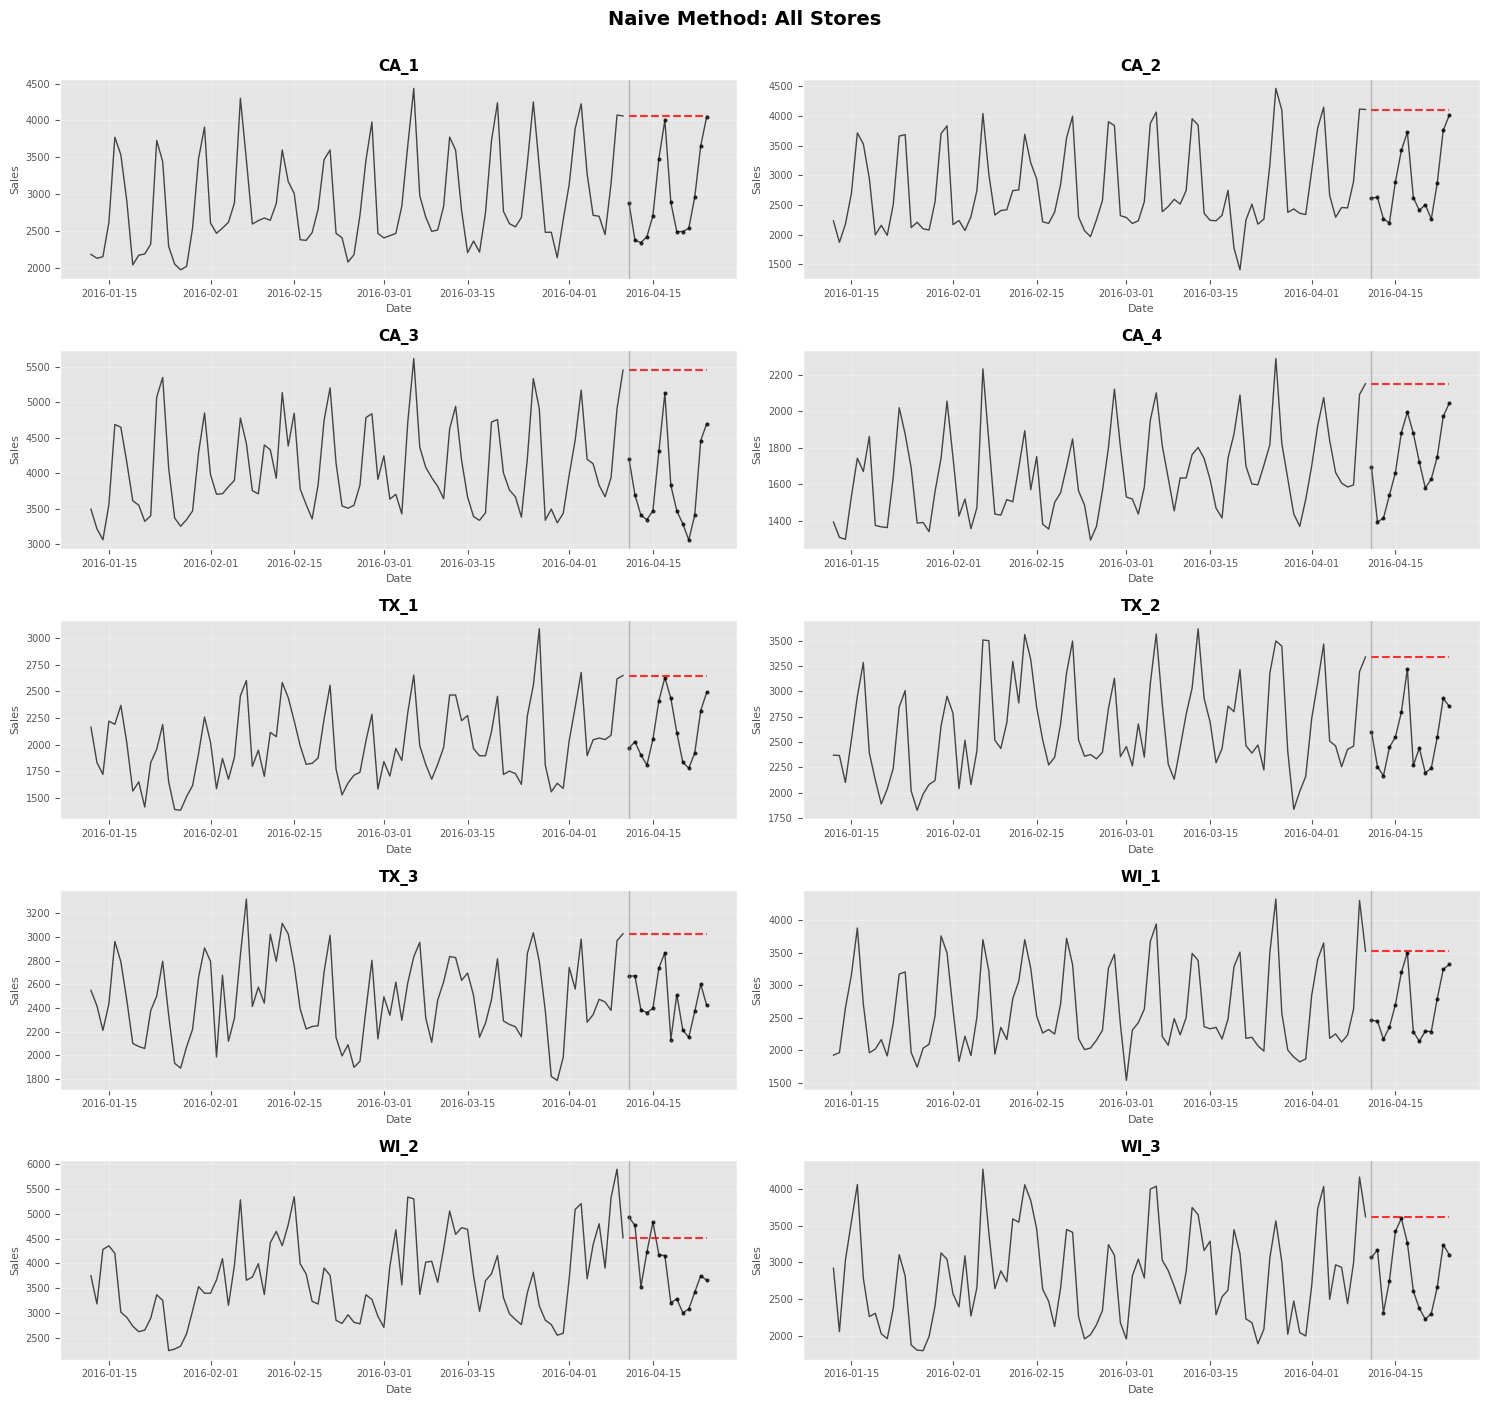

In [148]:
# Visualize Naive method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

stores = df_train['unique_id'].unique()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_naive[forecasts_naive['unique_id'] == store]
    
    # Plot last 90 days
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['Naive'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Naive Method: All Stores', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 7.2 Seasonal Naive Method

**Concept**: Use the value from the same season in the previous cycle.

**Formula**: ŷ_{t+h} = y_{t+h-m}

where m is the seasonal period (7 for weekly data)

**When to use**: Time series with clear seasonality (daily data with weekly patterns, monthly data with yearly patterns)

In [149]:
# Fit Seasonal Naive model with weekly seasonality (period=7)
sf_snaive = StatsForecast(
    models=[SeasonalNaive(season_length=7)],
    freq='D',
    n_jobs=-1
)

forecasts_snaive = sf_snaive.forecast(df=df_train, h=test_size)

print("Seasonal Naive Forecasts:")
print("="*60)
print(forecasts_snaive.head(14))  # Show 2 weeks
print("\n💡 Notice: The forecast repeats the pattern from 7 days ago!")

Seasonal Naive Forecasts:
   unique_id         ds  SeasonalNaive
0       CA_1 2016-04-11         3273.0
1       CA_1 2016-04-12         2711.0
2       CA_1 2016-04-13         2698.0
3       CA_1 2016-04-14         2450.0
4       CA_1 2016-04-15         3141.0
5       CA_1 2016-04-16         4073.0
6       CA_1 2016-04-17         4061.0
7       CA_1 2016-04-18         3273.0
8       CA_1 2016-04-19         2711.0
9       CA_1 2016-04-20         2698.0
10      CA_1 2016-04-21         2450.0
11      CA_1 2016-04-22         3141.0
12      CA_1 2016-04-23         4073.0
13      CA_1 2016-04-24         4061.0

💡 Notice: The forecast repeats the pattern from 7 days ago!


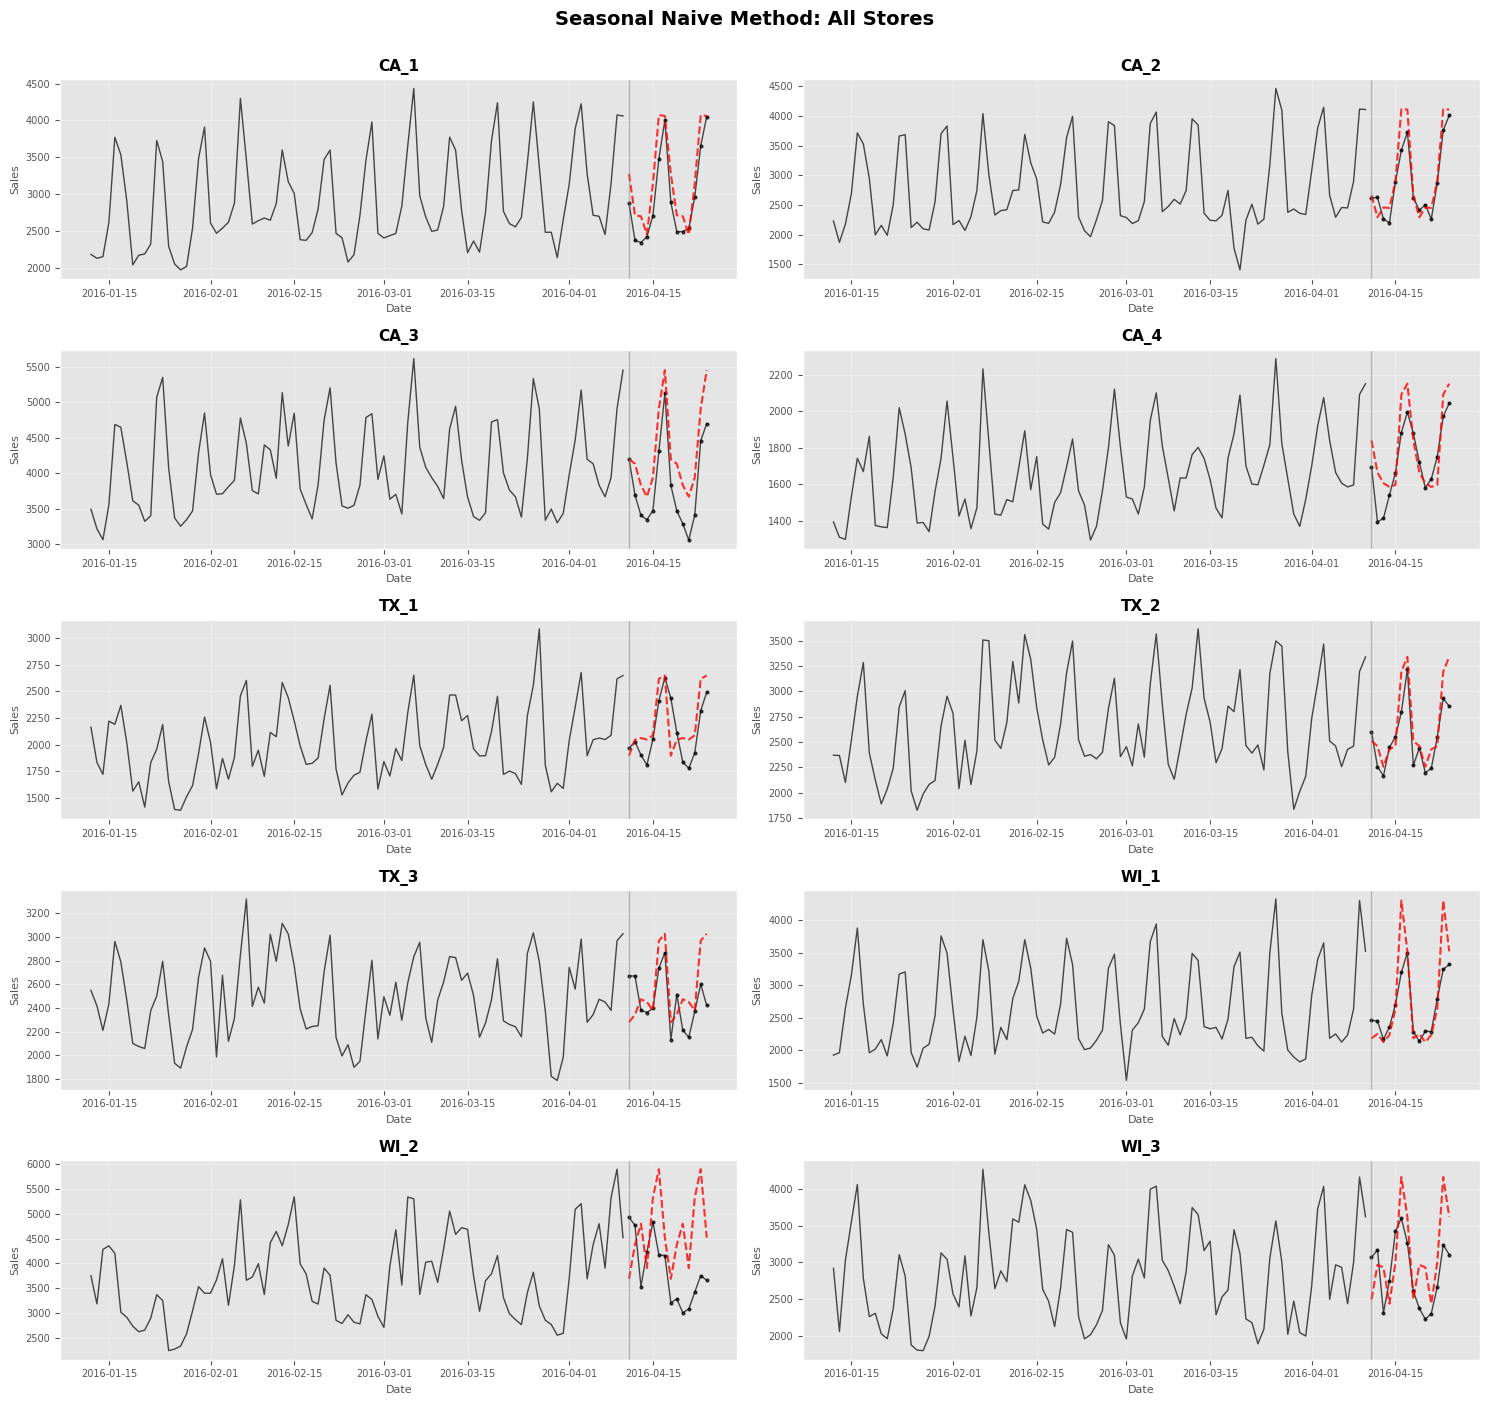

In [150]:
# Visualize Seasonal Naive method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_snaive[forecasts_snaive['unique_id'] == store]
    
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['SeasonalNaive'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Seasonal Naive Method: All Stores', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 7.3 Window Average (Moving Average)

**Concept**: Average the last N observations to smooth out noise.

**Formula**: ŷ_{t+h} = (y_t + y_{t-1} + ... + y_{t-N+1}) / N

**When to use**: Smooth out short-term fluctuations, when recent values are most relevant

In [151]:
# Fit Window Average model (using last 7 days)
sf_wavg = StatsForecast(
    models=[WindowAverage(window_size=7)],
    freq='D',
    n_jobs=-1
)

forecasts_wavg = sf_wavg.forecast(df=df_train, h=test_size)

print("Window Average Forecasts (7-day window):")
print("="*60)
print(forecasts_wavg.head(10))
print("\n💡 Notice: All forecasts are the same (average of last 7 days)!")

Window Average Forecasts (7-day window):
  unique_id         ds  WindowAverage
0      CA_1 2016-04-11         3201.0
1      CA_1 2016-04-12         3201.0
2      CA_1 2016-04-13         3201.0
3      CA_1 2016-04-14         3201.0
4      CA_1 2016-04-15         3201.0
5      CA_1 2016-04-16         3201.0
6      CA_1 2016-04-17         3201.0
7      CA_1 2016-04-18         3201.0
8      CA_1 2016-04-19         3201.0
9      CA_1 2016-04-20         3201.0

💡 Notice: All forecasts are the same (average of last 7 days)!


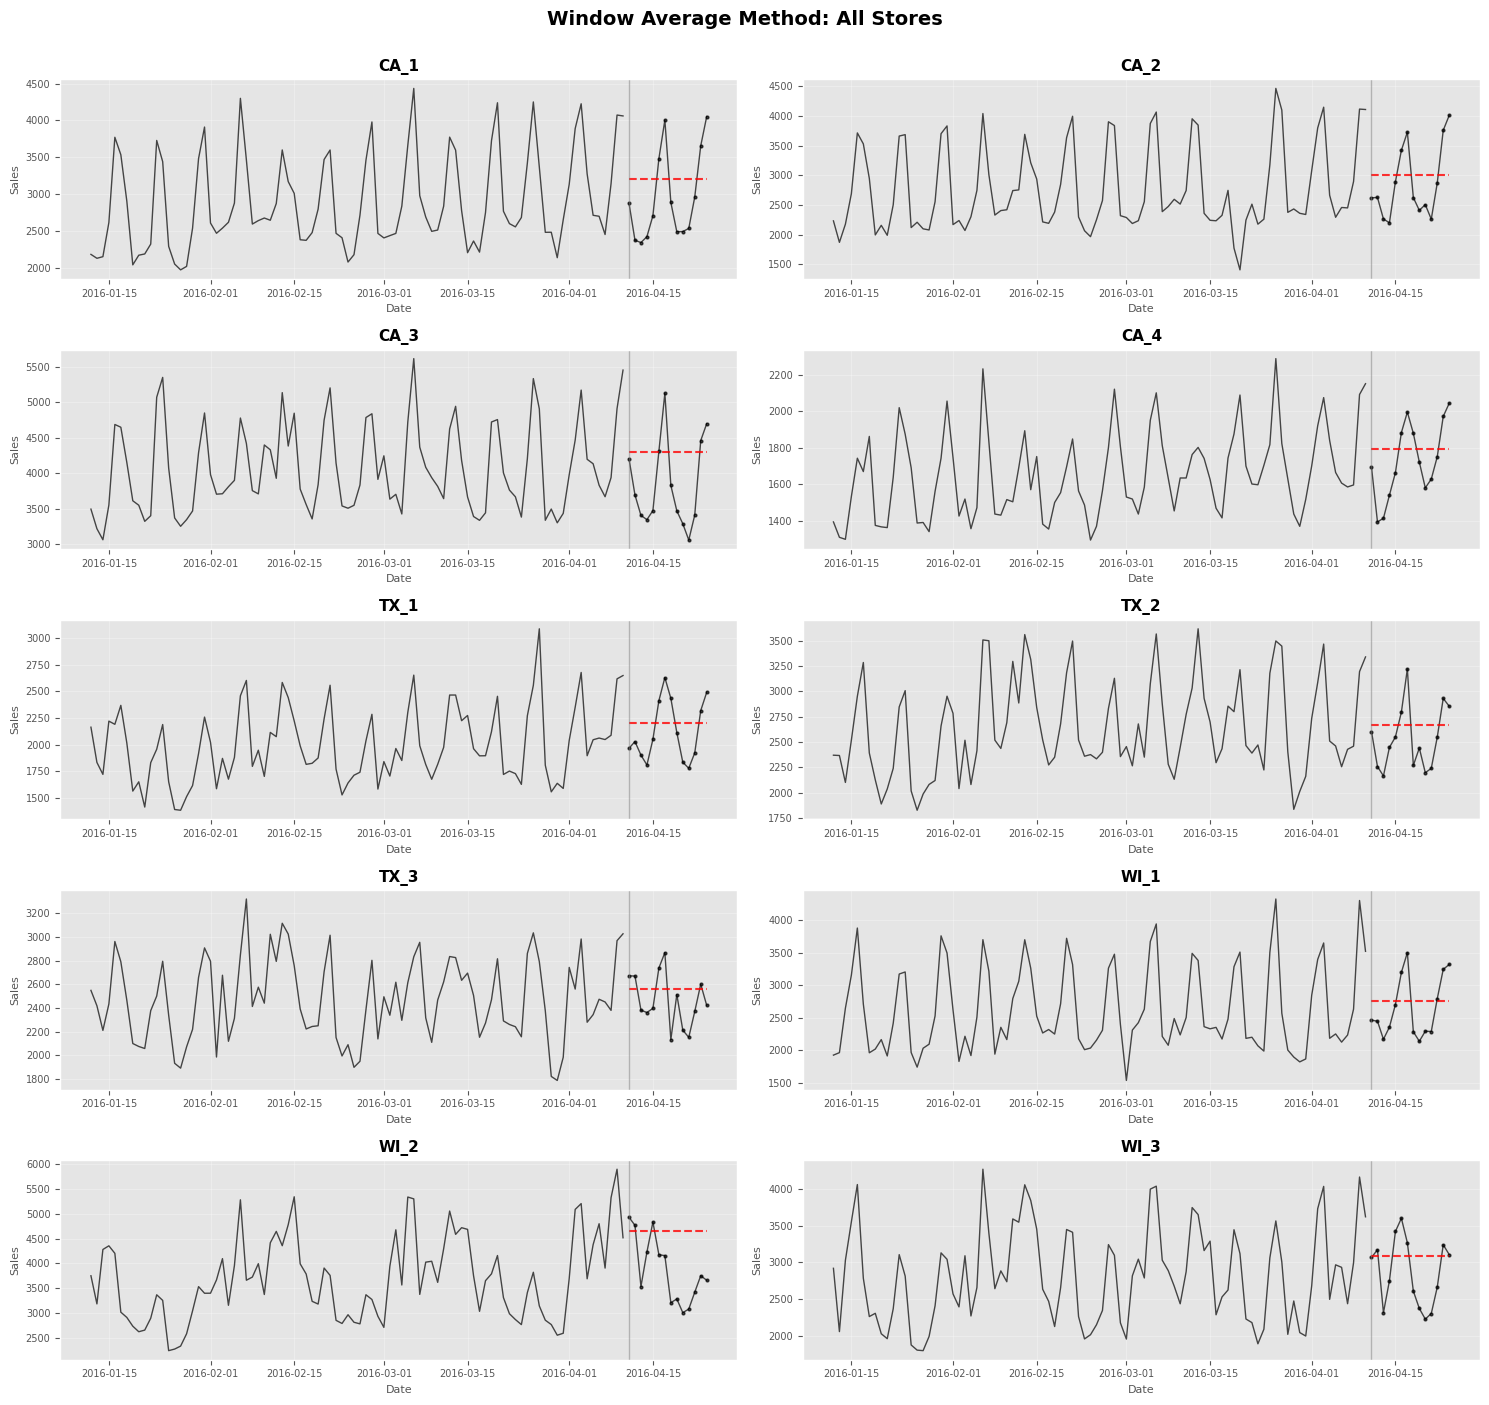

In [152]:
# Visualize Seasonal Window Average method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_wavg[forecasts_wavg['unique_id'] == store]
    
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['WindowAverage'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Window Average Method: All Stores', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 7.4 Seasonal Window Average

**Concept**: Combine seasonality with averaging - average the same weekday from the last N weeks.

**Example**: To forecast next Monday, average the last 2 Mondays

**When to use**: Seasonal data where averaging smooths noise but preserves patterns

In [153]:
# Fit Seasonal Window Average (last 2 weeks)
sf_swavg = StatsForecast(
    models=[SeasonalWindowAverage(season_length=7, window_size=2)],
    freq='D',
    n_jobs=-1
)

forecasts_swavg = sf_swavg.forecast(df=df_train, h=test_size)

print("Seasonal Window Average Forecasts:")
print("="*60)
print(forecasts_swavg.head(14))
print("\n💡 Each day is the average of the same weekday from last 2 weeks!")

Seasonal Window Average Forecasts:
   unique_id         ds  SeasWA
0       CA_1 2016-04-11  2876.5
1       CA_1 2016-04-12  2596.0
2       CA_1 2016-04-13  2416.5
3       CA_1 2016-04-14  2550.5
4       CA_1 2016-04-15  3136.5
5       CA_1 2016-04-16  3981.5
6       CA_1 2016-04-17  4143.5
7       CA_1 2016-04-18  2876.5
8       CA_1 2016-04-19  2596.0
9       CA_1 2016-04-20  2416.5
10      CA_1 2016-04-21  2550.5
11      CA_1 2016-04-22  3136.5
12      CA_1 2016-04-23  3981.5
13      CA_1 2016-04-24  4143.5

💡 Each day is the average of the same weekday from last 2 weeks!


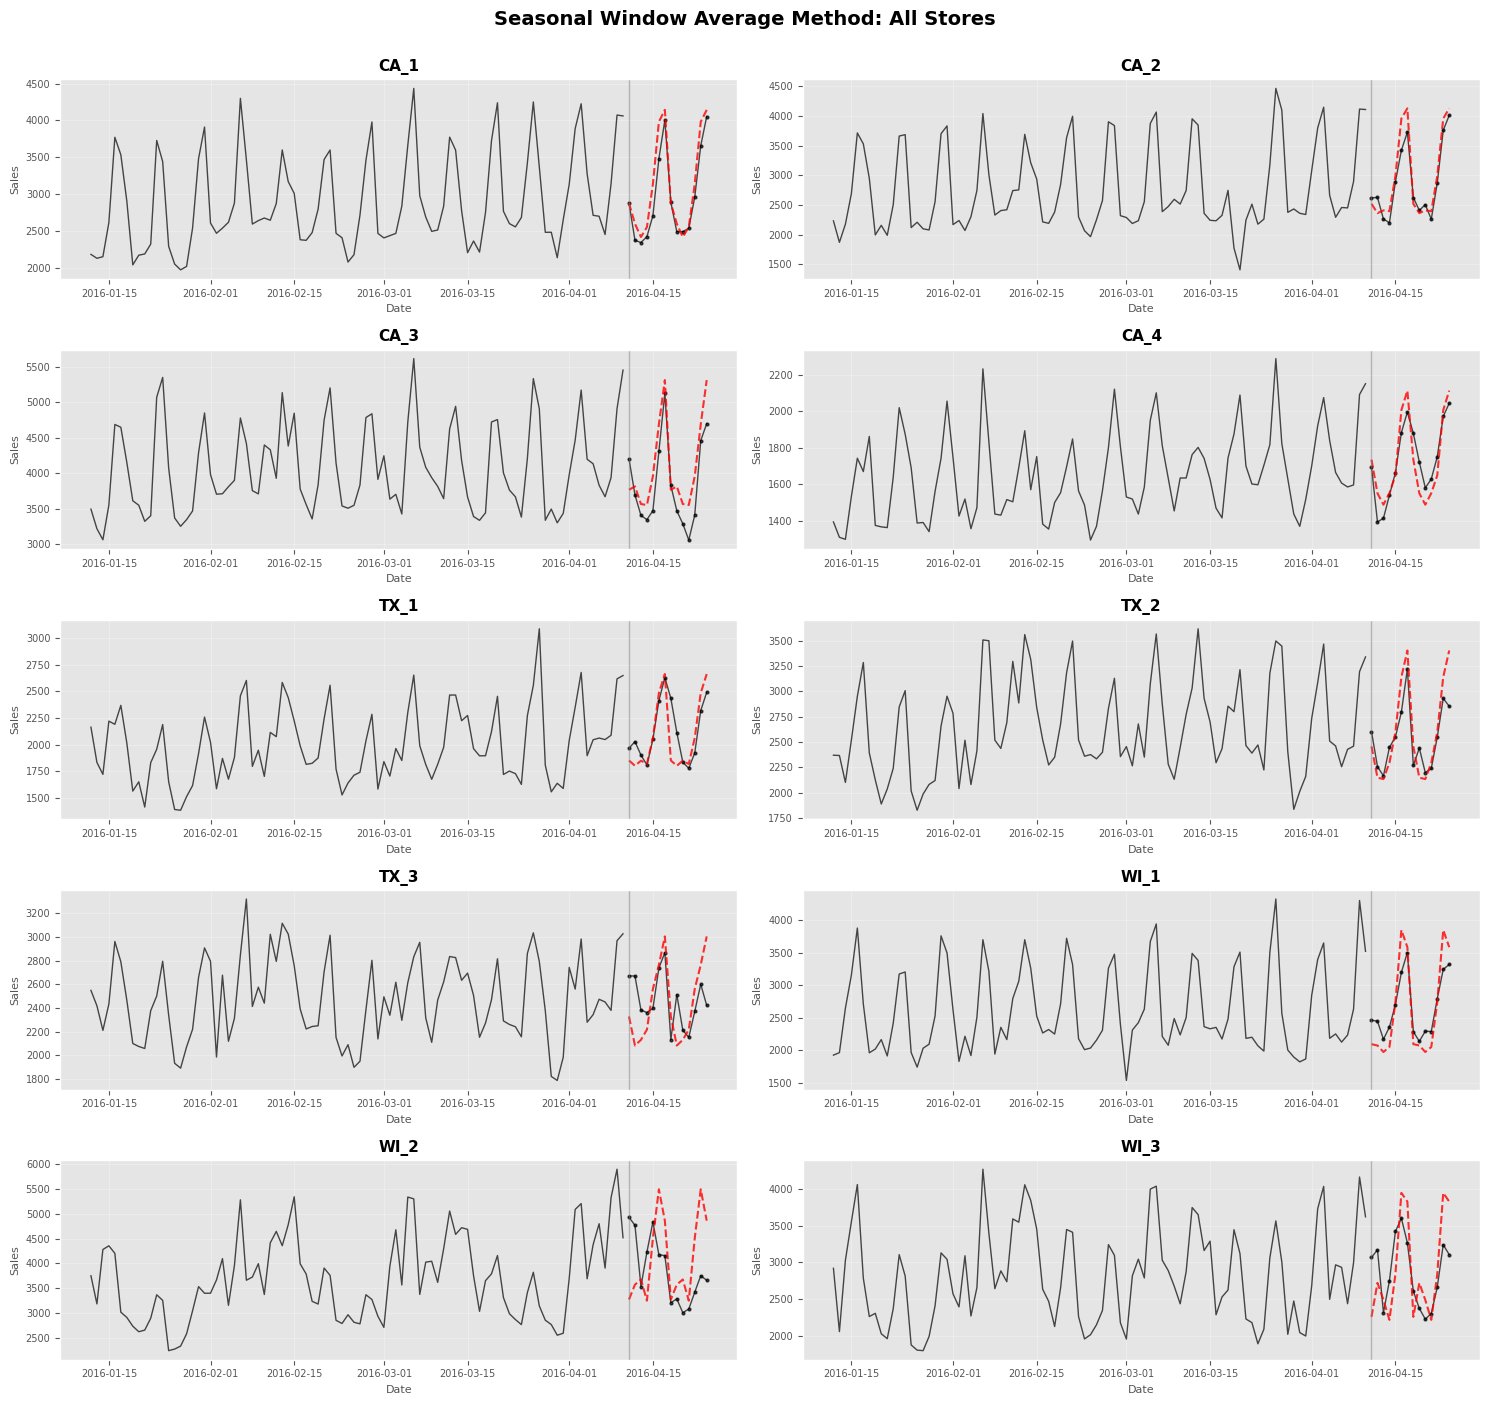

In [154]:
# Visualize Seasonal Window Average method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_swavg[forecasts_swavg['unique_id'] == store]
    
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['SeasWA'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Seasonal Window Average Method: All Stores', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. Statistical Models: Exponential Smoothing (ETS)

### What is Exponential Smoothing?

Exponential Smoothing is a family of forecasting methods based on **weighted averages** where:
- **Recent observations** get **MORE weight**
- **Older observations** get **LESS weight** (exponentially decaying)

**Key Idea**: ŷ = α·y_t + α(1-α)·y_{t-1} + α(1-α)²·y_{t-2} + ...

where α is the smoothing parameter (0 < α < 1)

### ETS Components

**E**rror, **T**rend, **S**easonality models can have:
- **Error**: Additive (A) or Multiplicative (M)
- **Trend**: None (N), Additive (A), Multiplicative (M), Damped (Ad/Md)
- **Seasonality**: None (N), Additive (A), Multiplicative (M)

### Why Exponential Smoothing?
- ✅ Uses ALL historical data (not just last value or season)
- ✅ Automatically adapts to changes in level, trend, and seasonality
- ✅ Fast and computationally efficient
- ✅ Produces smooth, realistic forecasts
- ✅ Provides prediction intervals (uncertainty)

Let's explore different ETS models by fitting them with different components!

### 8.1 Simple Exponential Smoothing (Level Only)

**Model**: ETS(A,N,N) - Additive Error, No Trend, No Seasonality

This is the simplest form - only captures the level (baseline).

In [155]:
# Import ETS models - using the proper ETS class for explicit component specification
from statsforecast.models import AutoETS

# For proper ETS specification, we'll use AutoETS with constraints
# ETS(A,N,N) = Level only (Additive Error, No Trend, No Seasonality)

# Fit ETS with LEVEL ONLY (A,N,N)
sf_ets_level = StatsForecast(
    models=[AutoETS(season_length=1, model='ANN')],  # ANN = Additive error, No trend, No seasonality
    freq='D',
    n_jobs=-1
)

forecasts_ets_level = sf_ets_level.forecast(df=df_train, h=test_size)

print("ETS (A,N,N) - Level Only:")
print("="*60)
print("\n💡 Notice: Forecasts are flat (captures only the baseline level)!")
forecasts_ets_level

ETS (A,N,N) - Level Only:

💡 Notice: Forecasts are flat (captures only the baseline level)!


unique_id         ds      AutoETS
0        CA_1 2016-04-11  3030.798584
1        CA_1 2016-04-12  3030.798584
2        CA_1 2016-04-13  3030.798584
3        CA_1 2016-04-14  3030.798584
4        CA_1 2016-04-15  3030.798584
..        ...        ...          ...
135      WI_3 2016-04-20  3477.482666
136      WI_3 2016-04-21  3477.482666
137      WI_3 2016-04-22  3477.482666
138      WI_3 2016-04-23  3477.482666
139      WI_3 2016-04-24  3477.482666

[140 rows x 3 columns]

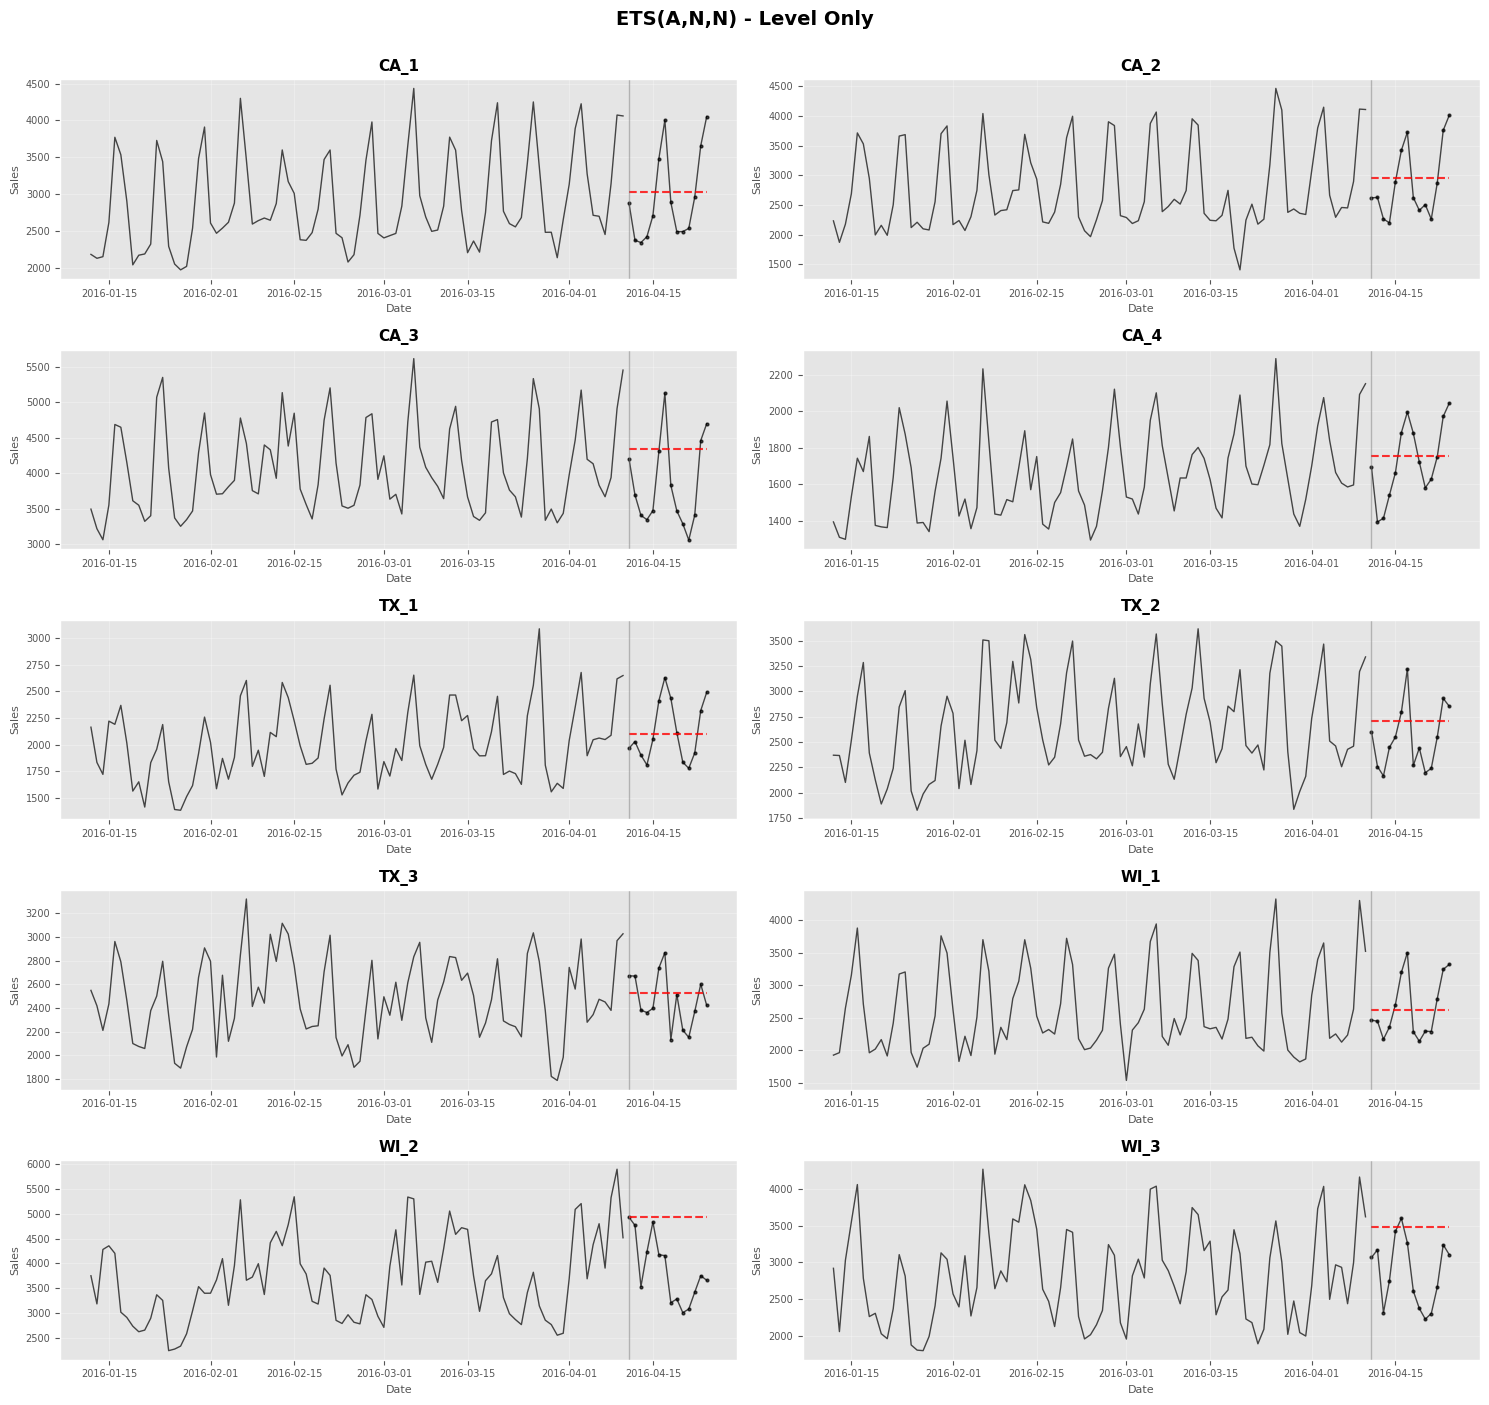

In [156]:
# Visualize AutoETS method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_ets_level[forecasts_ets_level['unique_id'] == store]
    
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['AutoETS'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Add prediction interval

    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('ETS(A,N,N) - Level Only', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 8.2 ETS with Level + Trend

**Model**: ETS(A,A,N) - Additive Error, Additive Trend, No Seasonality

This adds a trend component to capture growth or decline over time.

In [157]:
# Fit ETS with LEVEL + TREND (A,A,N)
sf_ets_trend = StatsForecast(
    models=[AutoETS(season_length=1, model='AAN')],  # AAN = Additive error, Additive trend, No seasonality
    freq='D',
    n_jobs=-1
)

forecasts_ets_trend = sf_ets_trend.forecast(df=df_train, h=test_size)

print("ETS(A,A,N) - Level + Trend:")
print("="*60)
print("\n💡 Notice: Forecasts show a trend (increasing/decreasing) but no seasonality!")
forecasts_ets_trend

ETS(A,A,N) - Level + Trend:

💡 Notice: Forecasts show a trend (increasing/decreasing) but no seasonality!


unique_id         ds      AutoETS
0        CA_1 2016-04-11  3090.038086
1        CA_1 2016-04-12  3095.790039
2        CA_1 2016-04-13  3101.427002
3        CA_1 2016-04-14  3106.951172
4        CA_1 2016-04-15  3112.364990
..        ...        ...          ...
135      WI_3 2016-04-20  3481.653809
136      WI_3 2016-04-21  3481.667480
137      WI_3 2016-04-22  3481.678711
138      WI_3 2016-04-23  3481.687500
139      WI_3 2016-04-24  3481.694580

[140 rows x 3 columns]

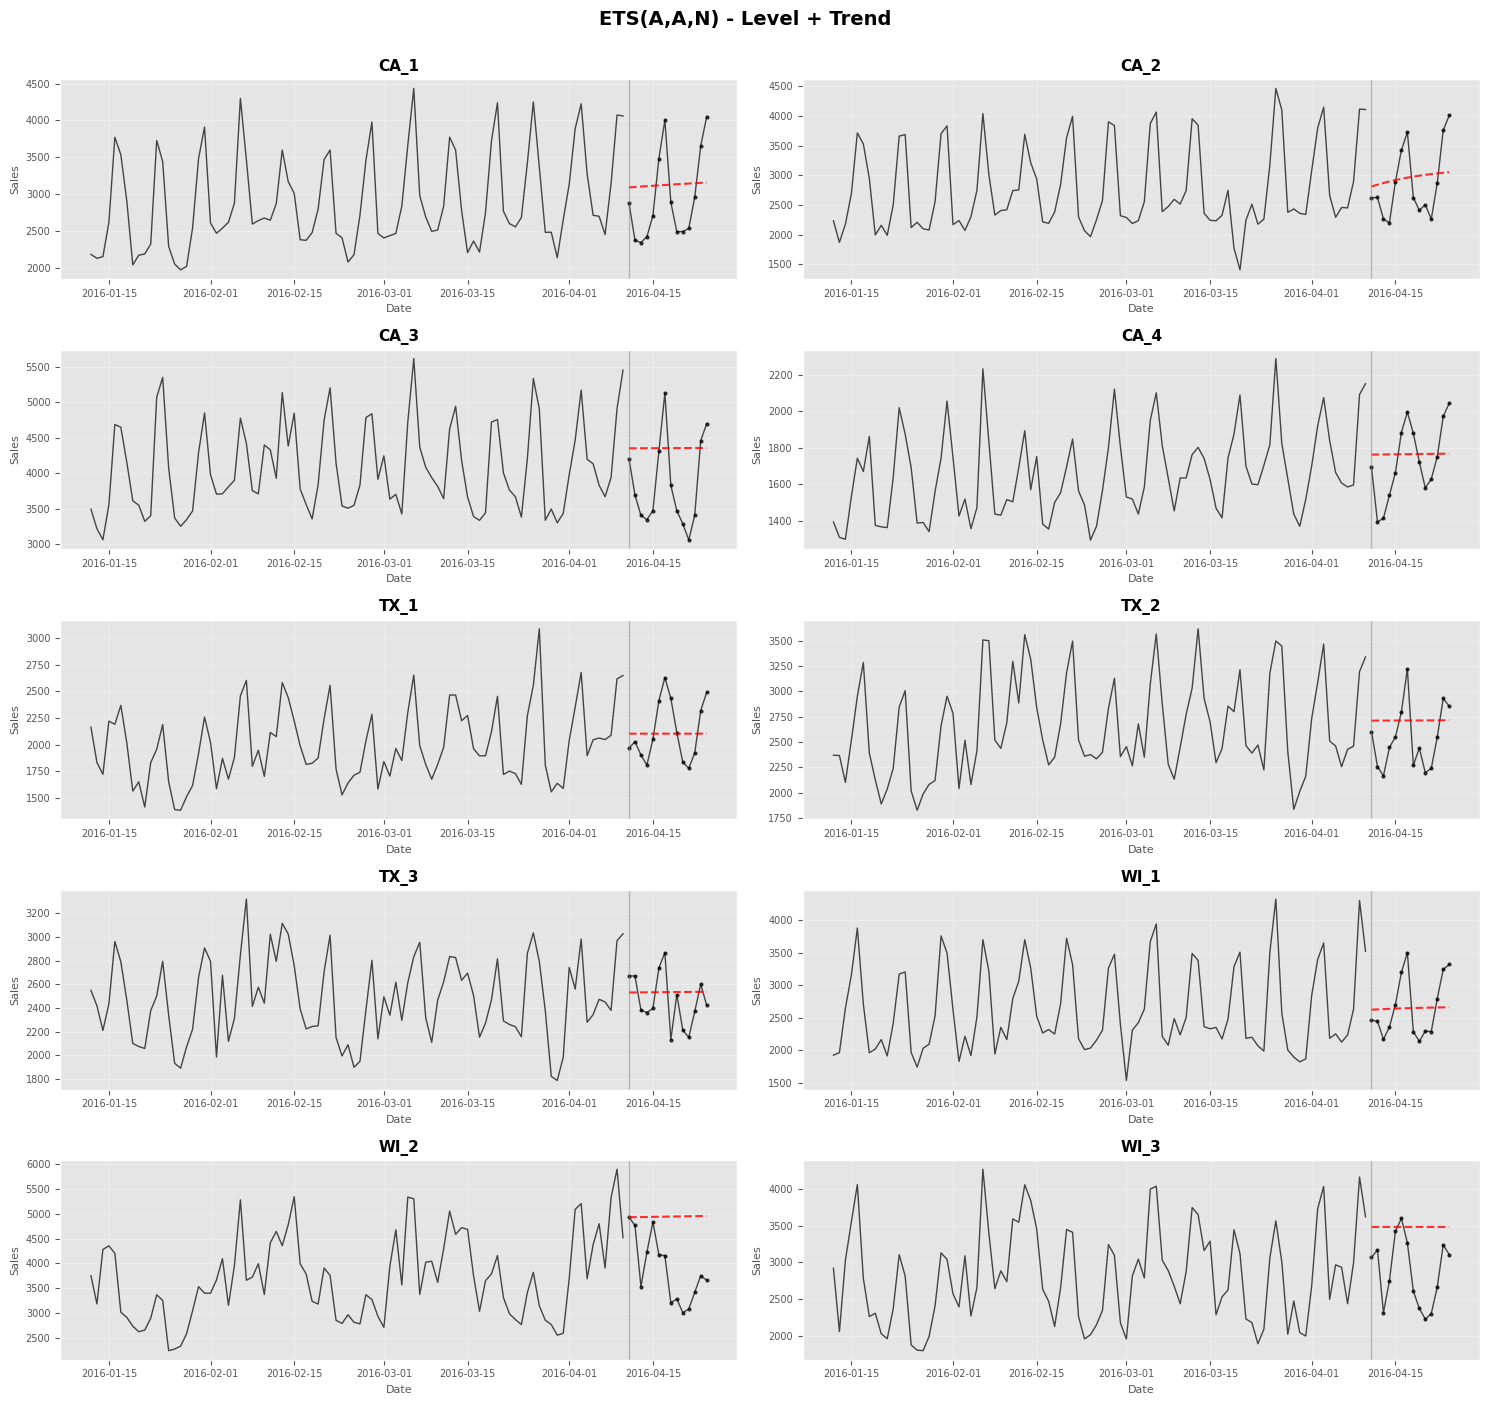

In [158]:
# Visualize AutoETS method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_ets_trend[forecasts_ets_trend['unique_id'] == store]
    
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['AutoETS'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Add prediction interval

    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('ETS(A,A,N) - Level + Trend', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 8.3 ETS with Level + Trend + Seasonality

**Model**: ETS(A,A,A) - Additive Error, Additive Trend, Additive Seasonality

This is the full ETS model with all three components!

In [159]:
# Fit ETS with LEVEL + TREND + SEASONALITY (A,A,A)
sf_ets_full = StatsForecast(
    models=[AutoETS(season_length=7, model='AAA')],  # AAA = Additive error, Additive trend, Additive seasonality
    freq='D',
    n_jobs=-1
)

forecasts_ets_full = sf_ets_full.forecast(df=df_train, h=test_size)

print("ETS(A,A,A) - Level + Trend + Seasonality:")
print("="*60)
print("\n✅ Notice: Forecasts have trend AND weekly seasonality!")
forecasts_ets_full

ETS(A,A,A) - Level + Trend + Seasonality:

✅ Notice: Forecasts have trend AND weekly seasonality!


unique_id         ds      AutoETS
0        CA_1 2016-04-11  3128.608887
1        CA_1 2016-04-12  2815.645264
2        CA_1 2016-04-13  2753.996582
3        CA_1 2016-04-14  2727.696777
4        CA_1 2016-04-15  3104.429688
..        ...        ...          ...
135      WI_3 2016-04-20  2895.662598
136      WI_3 2016-04-21  2962.311768
137      WI_3 2016-04-22  3199.428711
138      WI_3 2016-04-23  3851.598633
139      WI_3 2016-04-24  3626.686768

[140 rows x 3 columns]

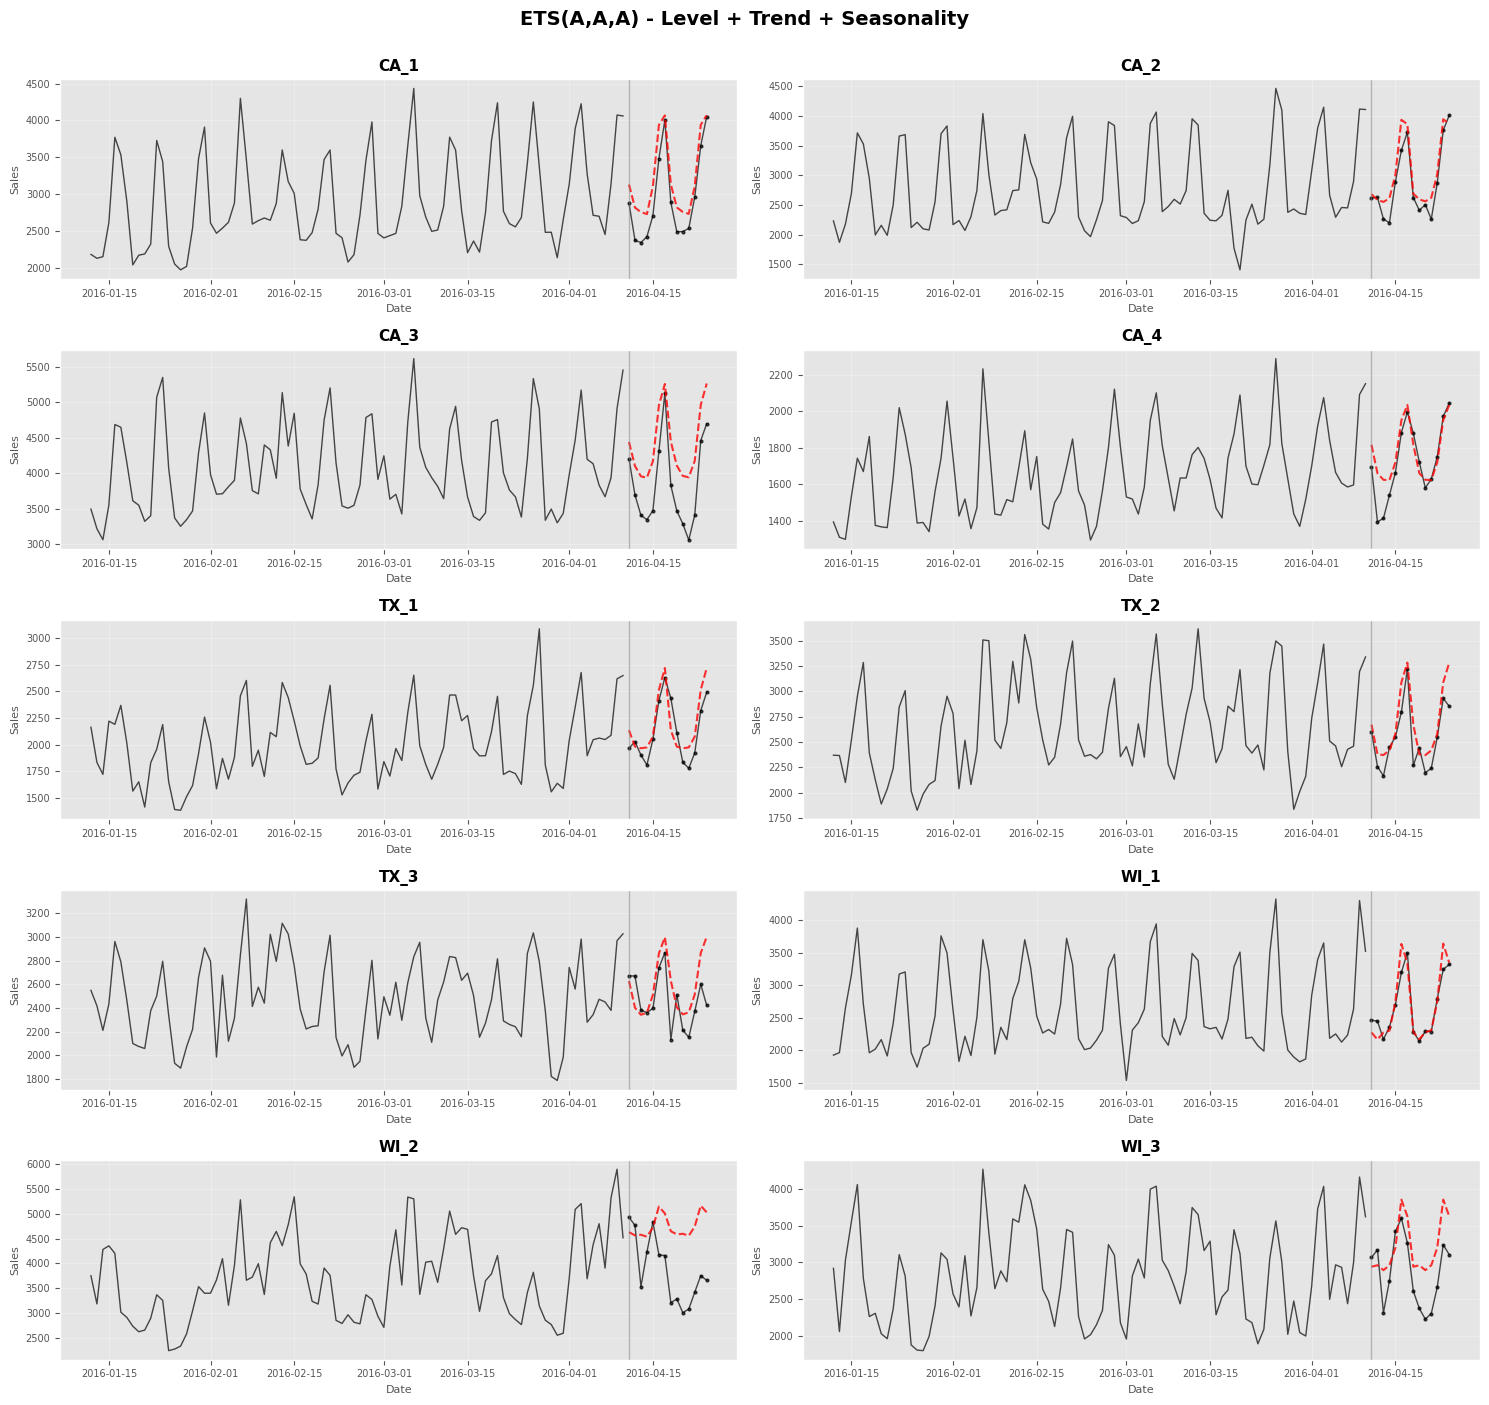

In [160]:
# Visualize AutoETS method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_ets_full[forecasts_ets_full['unique_id'] == store]
    
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['AutoETS'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Add prediction interval

    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('ETS(A,A,A) - Level + Trend + Seasonality', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 8.4 AutoETS (Automatic Component Selection)

**AutoETS** automatically tests different combinations and selects the best model!

It chooses the optimal:
- Error type (Additive or Multiplicative)
- Trend type (None, Additive, Damped, etc.)
- Seasonality type (None, Additive, Multiplicative)

In [161]:
# Fit AutoETS model
sf_ets = StatsForecast(
    models=[AutoETS(season_length=7)],
    freq='D',
    n_jobs=-1
)

# Generate forecasts with prediction intervals
forecasts_ets = sf_ets.forecast(df=df_train, h=test_size, level=[95])

print("AutoETS Forecasts (with 95% prediction intervals):")
print("="*60)
print("\nColumns:")
print("  AutoETS: Point forecast")
print("  AutoETS-lo-95: Lower bound (95% confidence)")
print("  AutoETS-hi-95: Upper bound (95% confidence)")
forecasts_ets

AutoETS Forecasts (with 95% prediction intervals):

Columns:
  AutoETS: Point forecast
  AutoETS-lo-95: Lower bound (95% confidence)
  AutoETS-hi-95: Upper bound (95% confidence)


unique_id         ds      AutoETS  AutoETS-lo-95  AutoETS-hi-95
0        CA_1 2016-04-11  3127.092773    2453.949463    3800.236084
1        CA_1 2016-04-12  2814.111084    2110.096436    3518.125488
2        CA_1 2016-04-13  2752.205322    2018.617676    3485.793213
3        CA_1 2016-04-14  2725.643311    1963.629272    3487.657471
4        CA_1 2016-04-15  3101.521729    2312.104004    3890.939209
..        ...        ...          ...            ...            ...
135      WI_3 2016-04-20  2752.300049    1018.161926    4486.437988
136      WI_3 2016-04-21  2792.391846    1002.609070    4582.174805
137      WI_3 2016-04-22  3223.467285    1361.693604    5085.241211
138      WI_3 2016-04-23  3793.976074    1836.282471    5751.669922
139      WI_3 2016-04-24  3675.906982    1631.755493    5720.058105

[140 rows x 5 columns]

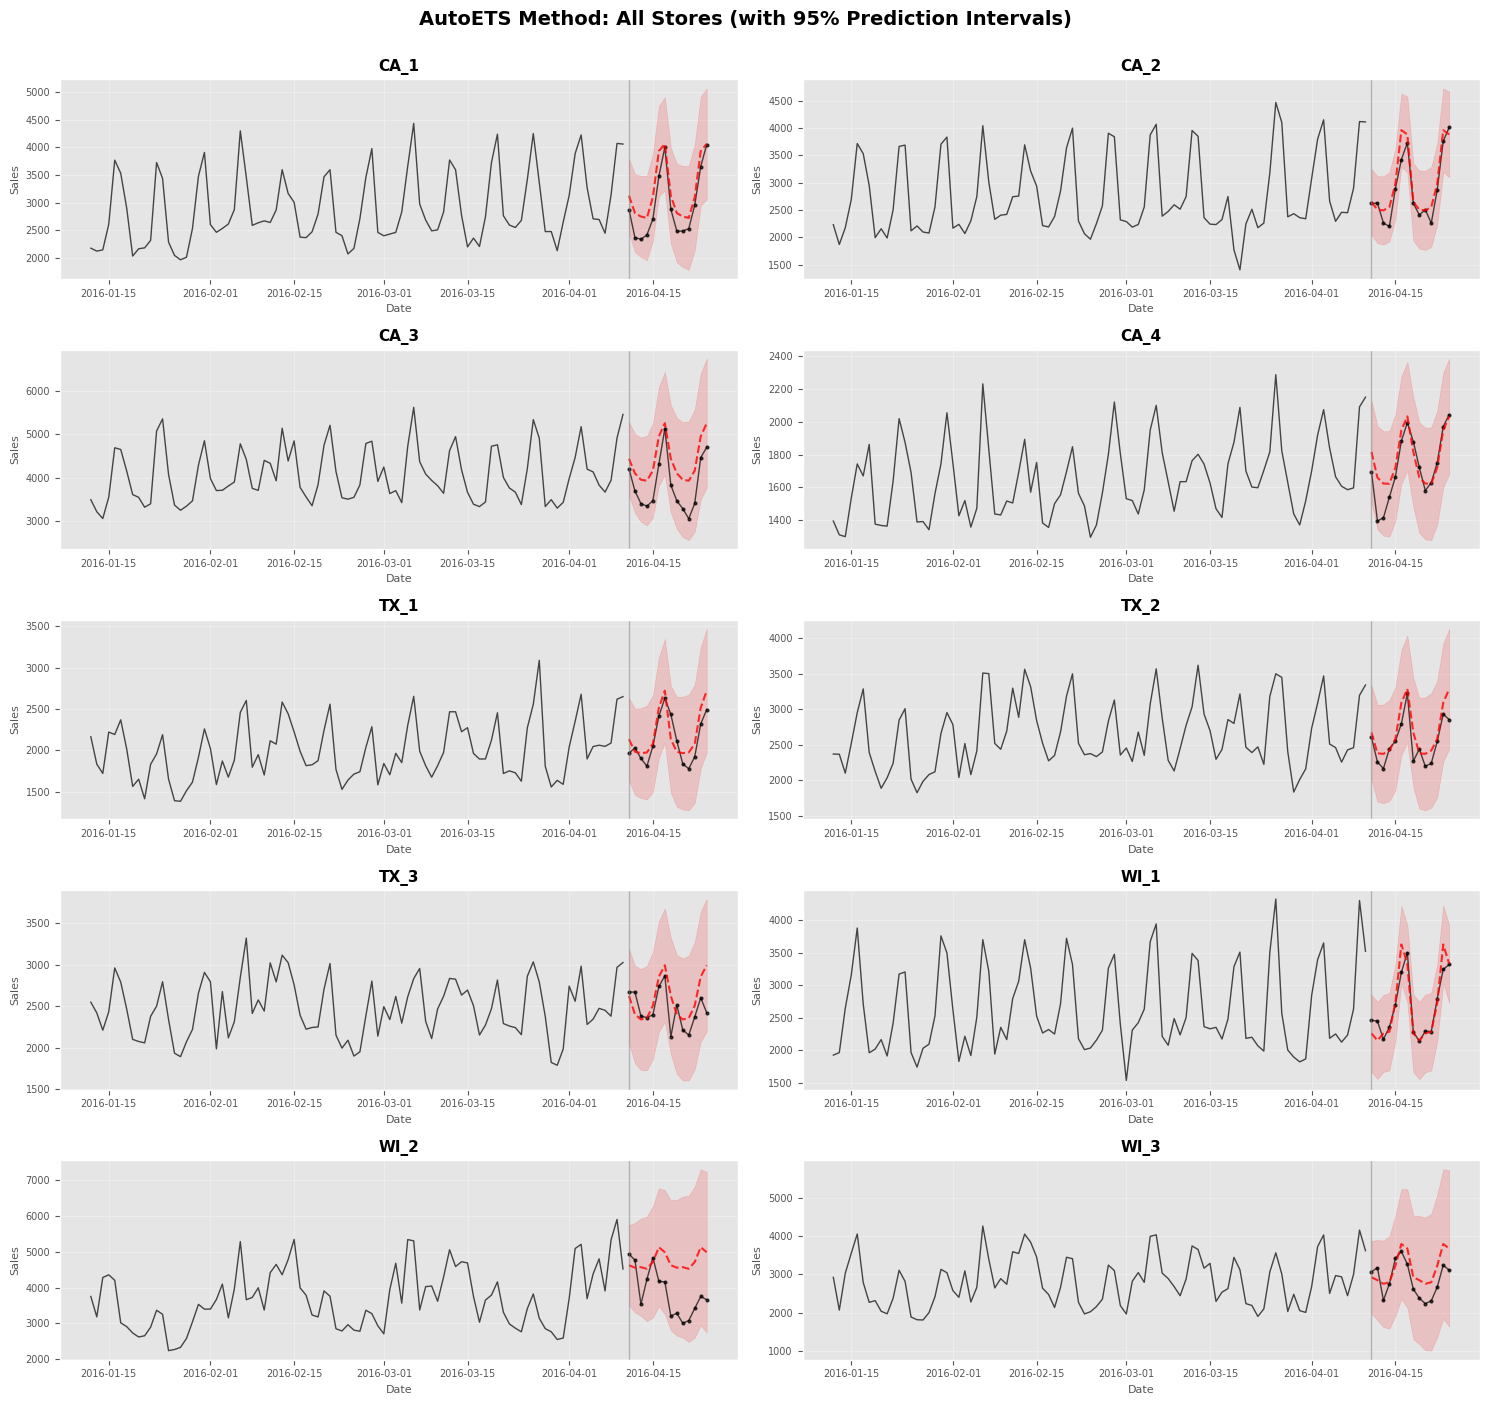


✅ AutoETS automatically selects the best components for each store!


In [162]:
# Visualize AutoETS method for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_ets[forecasts_ets['unique_id'] == store]
    
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1, alpha=0.7, marker='o', markersize=2)
    axes[idx].plot(forecast_store['ds'], forecast_store['AutoETS'], 
                   color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Add prediction interval
    axes[idx].fill_between(forecast_store['ds'], 
                           forecast_store['AutoETS-lo-95'], 
                           forecast_store['AutoETS-hi-95'],
                           color='red', alpha=0.15)
    
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    axes[idx].set_title(f'{store}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('AutoETS Method: All Stores (with 95% Prediction Intervals)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ AutoETS automatically selects the best components for each store!")

# 9 Forecasting All Models Together

Now let's forecast with **all models at once** and visualize them side-by-side for direct comparison!

This is a more efficient workflow - instead of fitting models one by one, we can fit them all together.

In [163]:
# Define all models in one list
all_models = [
    Naive(),
    SeasonalNaive(season_length=7),
    WindowAverage(window_size=7),
    SeasonalWindowAverage(season_length=7, window_size=2),
    AutoETS(season_length=7)
]

# Fit all models at once
sf_all_models = StatsForecast(
    models=all_models,
    freq='D',
    n_jobs=-1
)

# Generate forecasts for all models
print("Forecasting with all models...")
forecasts_all_models = sf_all_models.forecast(df=df_train, h=test_size)

print("✅ All models forecasted!")
print(f"\nForecast shape: {forecasts_all_models.shape}")
print(f"\nColumns: {list(forecasts_all_models.columns)}")
print(f"\nFirst few forecasts:")
forecasts_all_models.head(10)

Forecasting with all models...


✅ All models forecasted!

Forecast shape: (140, 7)

Columns: ['unique_id', 'ds', 'Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoETS']

First few forecasts:


unique_id         ds   Naive  SeasonalNaive  WindowAverage  SeasWA  \
0      CA_1 2016-04-11  4061.0         3273.0         3201.0  2876.5   
1      CA_1 2016-04-12  4061.0         2711.0         3201.0  2596.0   
2      CA_1 2016-04-13  4061.0         2698.0         3201.0  2416.5   
3      CA_1 2016-04-14  4061.0         2450.0         3201.0  2550.5   
4      CA_1 2016-04-15  4061.0         3141.0         3201.0  3136.5   
5      CA_1 2016-04-16  4061.0         4073.0         3201.0  3981.5   
6      CA_1 2016-04-17  4061.0         4061.0         3201.0  4143.5   
7      CA_1 2016-04-18  4061.0         3273.0         3201.0  2876.5   
8      CA_1 2016-04-19  4061.0         2711.0         3201.0  2596.0   
9      CA_1 2016-04-20  4061.0         2698.0         3201.0  2416.5   

       AutoETS  
0  3127.092773  
1  2814.111084  
2  2752.205322  
3  2725.643311  
4  3101.521729  
5  3934.068115  
6  4064.234375  
7  3127.092773  
8  2814.111084  
9  2752.205322

In [164]:
# Calculate MSE for each model and store for legend labels
from sklearn.metrics import mean_squared_error

model_names = ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoETS']

# Merge with actual test values
forecasts_all_with_actual = forecasts_all_models.merge(
    df_test[['unique_id', 'ds', 'y']], 
    on=['unique_id', 'ds'], 
    how='left'
)

# Calculate MSE for each model and store
mse_by_model_store = {}

for store in stores:
    mse_by_model_store[store] = {}
    store_data = forecasts_all_with_actual[forecasts_all_with_actual['unique_id'] == store]
    actual = store_data['y'].values
    
    for model in model_names:
        forecast = store_data[model].values
        mse = mean_squared_error(actual, forecast)
        mse_by_model_store[store][model] = mse

print("MSE calculated for all models and stores!")
print(f"\nExample for store CA_1:")
for model, mse in mse_by_model_store['CA_1'].items():
    print(f"  {model}: {mse:.0f}")

MSE calculated for all models and stores!

Example for store CA_1:
  Naive: 1579679
  SeasonalNaive: 100068
  WindowAverage: 404181
  SeasWA: 49382
  AutoETS: 89580


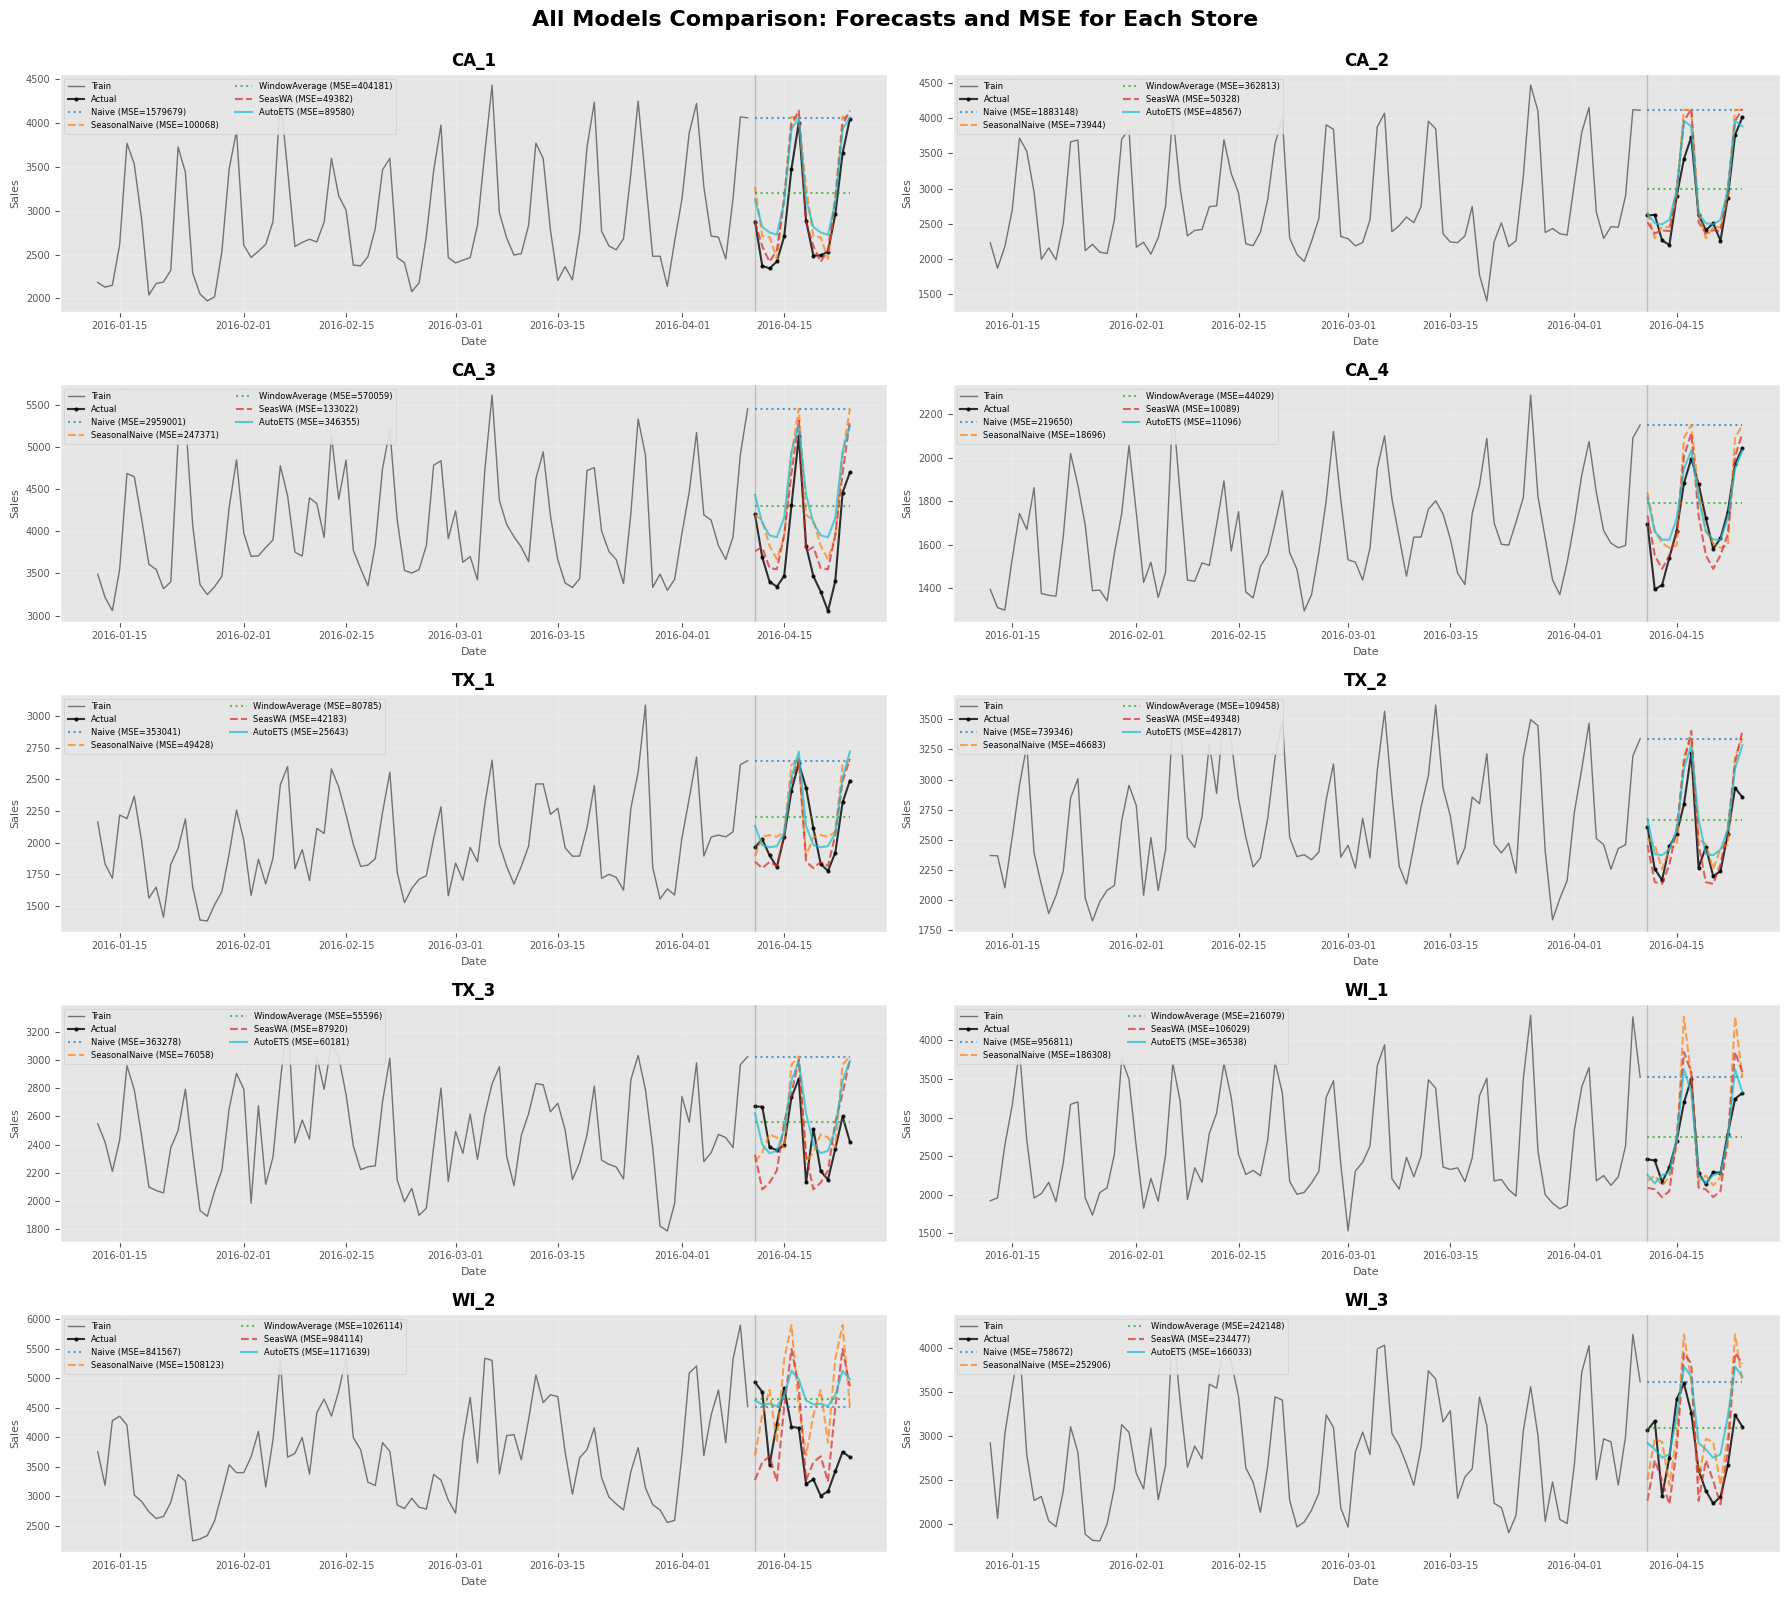


💡 Key Observations:
- Thicker lines (HoltWinters, AutoETS) = more sophisticated models
- MSE values in legend show which model performs best per store
- Notice how models with seasonality (dashed/solid) track actual better than flat forecasts (dotted)


In [165]:
# Visualize ALL models for ALL stores with MSE in legend
fig, axes = plt.subplots(5, 2, figsize=(18, 16))
axes = axes.flatten()

# Define colors and line styles for each model
model_styles = {
    'Naive': {'color': '#1f77b4', 'linestyle': ':', 'linewidth': 1.5},
    'SeasonalNaive': {'color': '#ff7f0e', 'linestyle': '--', 'linewidth': 1.5},
    'WindowAverage': {'color': '#2ca02c', 'linestyle': ':', 'linewidth': 1.5},
    'SeasWA': {'color': '#d62728', 'linestyle': '--', 'linewidth': 1.5},
    'AutoETS': {'color': '#17becf', 'linestyle': '-', 'linewidth': 1.5}
}

for idx, store in enumerate(stores):
    # Get data for this store
    train_store = df_train[df_train['unique_id'] == store]
    test_store = df_test[df_test['unique_id'] == store]
    forecast_store = forecasts_all_models[forecasts_all_models['unique_id'] == store]
    
    # Plot training data (last 90 days)
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['ds'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.5, label='Train')
    
    # Plot actual test data
    axes[idx].plot(test_store['ds'], test_store['y'], 
                   color='black', linewidth=1.5, alpha=0.8, marker='o', 
                   markersize=2, label='Actual')
    
    # Plot forecasts for each model with MSE in legend
    for model in model_names:
        mse = mse_by_model_store[store][model]
        style = model_styles[model]
        axes[idx].plot(forecast_store['ds'], forecast_store[model], 
                      color=style['color'], 
                      linestyle=style['linestyle'],
                      linewidth=style['linewidth'],
                      alpha=0.7,
                      label=f"{model} (MSE={mse:.0f})")
    
    # Mark train/test split
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', 
                     linewidth=1, alpha=0.4)
    
    axes[idx].set_title(f'{store}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.2)
    
    # Legend - place outside plot area
    axes[idx].legend(loc='upper left', fontsize=6, framealpha=0.9, ncol=2)

plt.suptitle('All Models Comparison: Forecasts and MSE for Each Store', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("- Thicker lines (HoltWinters, AutoETS) = more sophisticated models")
print("- MSE values in legend show which model performs best per store")
print("- Notice how models with seasonality (dashed/solid) track actual better than flat forecasts (dotted)")

### Discussion: Why Do These Results Make Sense?

Let's think about what we learned:

1. **Naive Method**: Poor performance
   - Ignores weekly seasonality completely
   - Only uses last value
   
2. **Seasonal Naive**: Much better!
   - Captures weekly pattern
   - Simple but effective for seasonal data
   
3. **Window Average**: Poor performance
   - Smooths out seasonality
   - Flat forecast misses peaks and valleys
   
4. **Seasonal Window Average**: Good performance
   - Combines seasonality with smoothing
   - Balances pattern and noise reduction
   
5. **AutoETS**: Best or near-best
   - Uses ALL historical data with smart weighting
   - Automatically adapts to level, trend, and seasonality
   - More sophisticated = better forecasts

**Key Takeaway**: For seasonal data (like our weekly patterns), methods that capture seasonality perform MUCH better than those that don't!

## 10. Summary

### What We Learned Today:

#### 1. **Time Series Data Formats**
   - Transactional format: efficient, scalable, supports covariates
   - Pivoted format: visual, but memory-intensive

#### 2. **Time Series Components**
   - **Level**: Baseline value
   - **Trend**: Long-term direction
   - **Seasonality**: Repeating patterns
   - **Noise**: Random fluctuations

#### 3. **Visualization & Decomposition**
   - Always visualize before modeling!
   - Decomposition reveals hidden patterns
   - Our data shows strong weekly seasonality

#### 4. **Simple Forecasting Methods**
   - **Naive**: Last value repeated (poor for seasonal data)
   - **Seasonal Naive**: Same season last cycle (good for seasonal data)
   - **Window Average**: Smoothed average (loses seasonality)
   - **Seasonal Window Average**: Seasonal + smoothing (balanced)

#### 5. **Statistical Models**
   - **Exponential Smoothing (ETS)**: Weighted averages with decay
   - Uses ALL historical data intelligently
   - AutoETS automatically selects best components
   - Often outperforms simple methods

#### 6. **Evaluation**
   - MSE measures forecast accuracy
   - Lower MSE = better forecasts
   - Methods that capture seasonality perform best

### Key Principles:

1. **Understand your data first** - visualization is crucial
2. **Match methods to patterns** - seasonal data needs seasonal methods
3. **Start simple** - baseline methods are powerful benchmarks
4. **Use all your data** - ETS leverages entire history
5. **Evaluate properly** - always test on held-out data

---

### 🎓 Congratulations!

You've completed Session 1 of the Time Series Forecasting Workshop. You now have a solid foundation in:
- Understanding time series structure
- Identifying patterns through decomposition
- Building and evaluating forecasting models
- Using StatsForecast for production-ready forecasting

**Keep practicing with different datasets and methods to build your forecasting skills!** 🚀